# Link Unet Membrane
https://www.kaggle.com/datasets/tasmiarahmanaanika/unet-lung-mask

In [2]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import tensorflow as tf

from glob import glob
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D

# Load Dataset Training dan Valid

In [3]:
# Function to replace NaN values with 0
def replace_nan_with_zero(df, columns=None, inplace=True):
    if columns is None:
        if inplace:
            df.fillna(0, inplace=True)
            return None
        else:
            return df.fillna(0)
    else:
        # limit replacement only to the specified columns
        if inplace:
            df[columns] = df[columns].fillna(0)
            return None
        else:
            new_df = df.copy()
            new_df[columns] = new_df[columns].fillna(0)
            return new_df

In [4]:
# Number of rows to sample
n_rows = 10000

# Read and sample randomly
train_df = pd.read_csv("train.csv")
train_df.drop(columns=['_id'], inplace=True, errors='ignore')
train_df = train_df.sample(n=n_rows, random_state=42) 
train_df = train_df.reset_index(drop=True) 
train_df.head()

Path     Sex  Age  \
0  D:/Downloads/train/patient00082/study1/view1_f...    Male   18   
1  D:/Downloads/train/patient35759/study9/view1_f...    Male   90   
2  D:/Downloads/train/patient04789/study1/view2_l...    Male   39   
3  D:/Downloads/train/patient38491/study5/view1_f...    Male   60   
4  D:/Downloads/train/patient06537/study3/view1_f...  Female   66   

  Frontal_Lateral AP_PA  No_Finding  Enlarged_Cardiomediastinum  Cardiomegaly  \
0         Frontal    PA           1                           0             0   
1         Frontal    AP           0                           0             1   
2         Lateral     0           0                           0             0   
3         Frontal    AP           0                           0             0   
4         Frontal    AP           0                           0             0   

   Lung_Opacity  Lung_Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0             0            0      0              0          0            0   
1             0            0      1              0          0            1   
2             0            1      0              0          0            0   
3             0            0      1              0          0            0   
4             1            0      0              0          0            1   

   Pneumothorax  Pleural_Effusion  Pleural_Other  Fracture  Support_Devices  
0             0                 0              0         0                0  
1             0                 0              0         0                1  
2             0                 1              0         0                0  
3             0                 0              0         0                1  
4             0                 0              0         0                0

In [5]:
# Function to prepare dataset based on labeling policy 
def prepare_dataset(dataframe, policy, class_names):
    df = dataframe.sample(frac=1.0, random_state=1)
    x_path = df["Path"].to_numpy()
    
    y_df = df[class_names]
    
    class_ones = ['Atelectasis', 'Cardiomegaly'] 
    y = np.empty(y_df.shape, dtype=int)
    
    for i, (_, row) in enumerate(y_df.iterrows()):
        labels = []
        for cls in class_names:
            curr_val = row[cls]
            feat_val = 0

            if curr_val is not None:
                try:
                    curr_val = float(curr_val)
                except:
                    curr_val = 0

                if curr_val == 1:
                    feat_val = 1
                elif curr_val == -1:
                    if policy == "ones":
                        feat_val = 1
                    elif policy == "zeroes":
                        feat_val = 0
                    elif policy == "mixed":
                        feat_val = 1 if cls in class_ones else 0
                else:
                    feat_val = 0
            labels.append(feat_val)
        y[i] = labels
    
    return x_path, y


In [6]:
# Classes used based on CheXpert paper
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural_Effusion']
policy = ['ones','zeroes','mixed']
x_path,labels = prepare_dataset(train_df,policy[-1],class_names)

In [7]:
print(x_path)

['D:/Downloads/train/patient14339/study4/view1_frontal.jpg'
 'D:/Downloads/train/patient33200/study1/view1_frontal.jpg'
 'D:/Downloads/train/patient13227/study13/view1_frontal.jpg' ...
 'D:/Downloads/train/patient48113/study1/view1_frontal.jpg'
 'D:/Downloads/train/patient02044/study2/view1_frontal.jpg'
 'D:/Downloads/train/patient35025/study9/view1_frontal.jpg']


In [8]:
# Get data
train_df = pd.DataFrame({'path':x_path})
df2 = pd.DataFrame(labels,columns=class_names)
train_df[list(df2.columns)]=df2 

In [9]:
train_df

path  Atelectasis  \
0     D:/Downloads/train/patient14339/study4/view1_f...            0   
1     D:/Downloads/train/patient33200/study1/view1_f...            0   
2     D:/Downloads/train/patient13227/study13/view1_...            0   
3     D:/Downloads/train/patient37912/study12/view1_...            0   
4     D:/Downloads/train/patient32046/study3/view1_f...            1   
...                                                 ...          ...   
9995  D:/Downloads/train/patient00674/study2/view1_f...            1   
9996  D:/Downloads/train/patient41032/study2/view1_f...            0   
9997  D:/Downloads/train/patient48113/study1/view1_f...            0   
9998  D:/Downloads/train/patient02044/study2/view1_f...            0   
9999  D:/Downloads/train/patient35025/study9/view1_f...            1   

      Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0                0              0      0                 0  
1                0              0      0                 1  
2                0              0      0                 0  
3                0              0      1                 0  
4                0              0      0                 1  
...            ...            ...    ...               ...  
9995             0              0      1                 1  
9996             1              0      0                 0  
9997             0              0      0                 0  
9998             1              0      1                 1  
9999             0              0      0                 1  

[10000 rows x 6 columns]

Clean Labels Summary:
Pleural_Effusion    3830
Atelectasis         3019
Edema               2308
Cardiomegaly        1546
Consolidation        628
dtype: int64


(<Axes: xlabel='None', ylabel='0'>,
 ([0, 1, 2, 3, 4],
  [Text(0, 0, 'Pleural_Effusion'),
   Text(1, 0, 'Atelectasis'),
   Text(2, 0, 'Edema'),
   Text(3, 0, 'Cardiomegaly'),
   Text(4, 0, 'Consolidation')]))

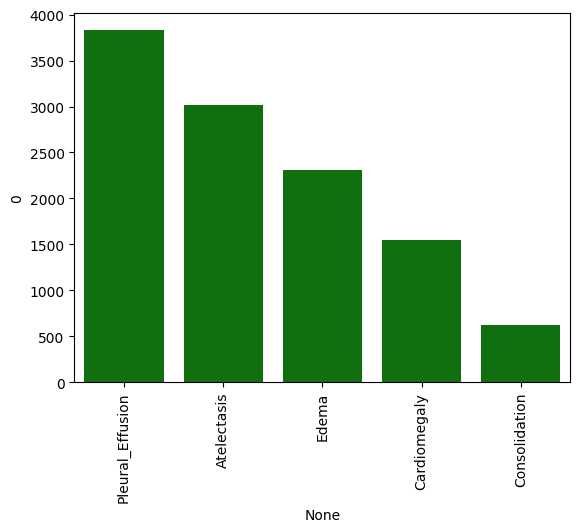

In [10]:
print("Clean Labels Summary:")
clean_labels = train_df[class_names].sum().sort_values(ascending= False) # get sorted value_count for clean labels
print(clean_labels) # view tabular results

# plot cases using seaborn barchart
clean_labels_df = clean_labels.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [11]:
# get valid dataset
valid_df = pd.read_csv("valid.csv")
valid_df.drop(columns=['_id'], inplace=True, errors='ignore')
# Replace any NaNs with 0 
replace_nan_with_zero(valid_df)
valid_df.head()

Path     Sex  Age  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...    Male   73   
1  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
2  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
3  CheXpert-v1.0-small/valid/patient64543/study1/...    Male   85   
4  CheXpert-v1.0-small/valid/patient64544/study1/...  Female   42   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         0.0                         1.0           1.0   
1         Frontal    PA         0.0                         0.0           0.0   
2         Lateral     0         0.0                         0.0           0.0   
3         Frontal    AP         0.0                         1.0           0.0   
4         Frontal    AP         1.0                         0.0           0.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           1.0          0.0    0.0            0.0        0.0          0.0   
1           0.0          0.0    0.0            0.0        0.0          0.0   
2           0.0          0.0    0.0            0.0        0.0          0.0   
3           1.0          0.0    1.0            0.0        0.0          0.0   
4           0.0          0.0    0.0            0.0        0.0          0.0   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               0.0            0.0       0.0              0.0  
1           0.0               0.0            0.0       0.0              1.0  
2           0.0               0.0            0.0       0.0              1.0  
3           0.0               0.0            0.0       0.0              0.0  
4           0.0               0.0            0.0       0.0              0.0

In [12]:
my_glob_valid = [x.replace('\\', '/') for x in glob('D:/Downloads/valid/patient*/study*/*.jpg')]
print('Number of Observations: ', len(my_glob_valid)) 

Number of Observations:  234


In [13]:
images_directory_valid = "D:/Downloads/valid"

full_img_paths = {}

# Full image mapping (source images)
for x in my_glob_valid:
    rel_path = os.path.relpath(x, images_directory_valid)
    key = 'CheXpert-v1.0-small/valid/' + rel_path.replace('\\', '/')
    full_img_paths[key] = x.replace('\\', '/')
    
# Map the correct paths to the dataframe
valid_df['Path'] = valid_df['Path'].map(full_img_paths.get)
valid_df.columns = valid_df.columns.str.replace(' ', '_')

In [14]:
valid_x_path,valid_labels = prepare_dataset(valid_df,policy[-1],class_names)

In [15]:
valid_df = pd.DataFrame({'path':valid_x_path})
df2 = pd.DataFrame(labels,columns=class_names)
valid_df[list(df2.columns)]=df2 
valid_df

path  Atelectasis  \
0    D:/Downloads/valid/patient64706/study1/view1_f...            0   
1    D:/Downloads/valid/patient64592/study1/view1_f...            0   
2    D:/Downloads/valid/patient64740/study1/view1_f...            0   
3    D:/Downloads/valid/patient64570/study1/view1_f...            0   
4    D:/Downloads/valid/patient64647/study1/view1_f...            1   
..                                                 ...          ...   
229  D:/Downloads/valid/patient64710/study1/view1_f...            0   
230  D:/Downloads/valid/patient64646/study1/view1_f...            1   
231  D:/Downloads/valid/patient64594/study1/view2_l...            1   
232  D:/Downloads/valid/patient64649/study1/view1_f...            1   
233  D:/Downloads/valid/patient64568/study1/view1_f...            1   

     Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0               0              0      0                 0  
1               0              0      0                 1  
2               0              0      0                 0  
3               0              0      1                 0  
4               0              0      0                 1  
..            ...            ...    ...               ...  
229             0              0      1                 1  
230             0              0      0                 0  
231             0              0      0                 0  
232             1              1      1                 1  
233             0              0      0                 0  

[234 rows x 6 columns]

In [16]:
my_glob_train = train_df['path'].tolist()
print('Number of Observations: ', len(my_glob_train)) 

Number of Observations:  10000


In [17]:
print(my_glob_train)

['D:/Downloads/train/patient14339/study4/view1_frontal.jpg', 'D:/Downloads/train/patient33200/study1/view1_frontal.jpg', 'D:/Downloads/train/patient13227/study13/view1_frontal.jpg', 'D:/Downloads/train/patient37912/study12/view1_frontal.jpg', 'D:/Downloads/train/patient32046/study3/view1_frontal.jpg', 'D:/Downloads/train/patient32680/study3/view1_frontal.jpg', 'D:/Downloads/train/patient58692/study1/view1_frontal.jpg', 'D:/Downloads/train/patient23729/study5/view1_frontal.jpg', 'D:/Downloads/train/patient33805/study1/view2_lateral.jpg', 'D:/Downloads/train/patient03763/study21/view1_frontal.jpg', 'D:/Downloads/train/patient01494/study2/view1_frontal.jpg', 'D:/Downloads/train/patient25069/study5/view1_frontal.jpg', 'D:/Downloads/train/patient40497/study4/view2_lateral.jpg', 'D:/Downloads/train/patient33155/study4/view1_frontal.jpg', 'D:/Downloads/train/patient29597/study1/view2_lateral.jpg', 'D:/Downloads/train/patient13660/study1/view1_frontal.jpg', 'D:/Downloads/train/patient22306/stu

# Resize Gambar

In [18]:
import cv2
import numpy as np

# function to resize input image with padding
def resize_with_padding(img, target_size=224, pad_color=0):
    h, w = img.shape[:2]

    # Scale with ratio maintained
    if h > w:
        new_h = target_size
        new_w = int(w * (target_size / h))
    else:
        new_w = target_size
        new_h = int(h * (target_size / w))

    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Calculate padding
    pad_vert = target_size - new_h
    pad_horz = target_size - new_w

    top = pad_vert // 2
    bottom = pad_vert - top
    left = pad_horz // 2
    right = pad_horz - left

    # Add padding
    padded = cv2.copyMakeBorder(
        resized,
        top, bottom, left, right,
        cv2.BORDER_CONSTANT,
        value=pad_color,
    )

    return padded


In [19]:
def get_all_images(root_dir):
    exts = [".png", ".jpg", ".jpeg", ".bmp"]
    collected = []

    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if any(f.lower().endswith(e) for e in exts):
                collected.append(os.path.join(root, f))

    return collected

Pengaturan Direktori dan Resize Gambar

In [20]:
import cv2
from tqdm import tqdm

# resized directory 
resized_valid = "D:/Downloads/valid_resized"
resized_train = "D:/Downloads/train_resized"

TARGET_SIZE = 256
PAD_COLOR = 0 

In [21]:
def resize_images(my_glob, resized_output_dir):
    processed = 0
    failed = 0
    
    os.makedirs(resized_output_dir, exist_ok=True)
    
    glob = []
    valid_extensions = {".jpg", ".jpeg", ".png"}

    for root, dirs, files in os.walk(resized_output_dir):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions:
                glob.append(os.path.join(root, file))
    
    if glob:
        print(f"Found {len(glob)} resized images.")
        return glob
    else:
        print("No resized images found.")

        for img_path in tqdm(my_glob, desc="Resizing images"):
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            if img is None:
                print(f"Failed to read image: {img_path}")
                failed += 1
                continue

            resized_img = resize_with_padding(img, target_size=TARGET_SIZE, pad_color=PAD_COLOR)

            # Build relative path from the glob path
            parts = img_path.replace("\\", "/").split("/")
            rel = "/".join(parts[3:])  # keep everything after the top-level folder

            out_path = os.path.join(resized_output_dir, rel)
            os.makedirs(os.path.dirname(out_path), exist_ok=True)

            if resized_img.dtype != np.uint8:
                max_val = resized_img.max() or 1.0
                if max_val <= 1.0:
                    save_img = (resized_img * 255).astype(np.uint8)
                else:
                    save_img = resized_img.astype(np.uint8)
            else:
                save_img = resized_img

            success = cv2.imwrite(out_path, save_img)
            if not success:
                print(f"Failed to save: {out_path}")
                failed += 1
                continue
            
            processed += 1
            glob.append(out_path)
            
        print(f"Done. Processed: {processed}, Failed: {failed}")    
        return glob


In [22]:
glob_valid_resize = resize_images(my_glob_valid, resized_valid)

Found 234 resized images.


In [23]:
glob_train_resize = resize_images(my_glob_train, resized_train)

Found 10000 resized images.


In [24]:
print(glob_valid_resize)

['D:/Downloads/valid_resized\\patient64541\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64542\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64542\\study1\\view2_lateral.jpg', 'D:/Downloads/valid_resized\\patient64543\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64544\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64545\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64546\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64547\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64547\\study1\\view2_frontal.jpg', 'D:/Downloads/valid_resized\\patient64547\\study1\\view3_lateral.jpg', 'D:/Downloads/valid_resized\\patient64548\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64549\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64550\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64551\\study1\\view1_frontal.jpg', 'D:/D

In [25]:
print(glob_train_resize)

['D:/Downloads/train_resized\\patient00006\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00012\\study3\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00023\\study6\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00039\\study7\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00042\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00059\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00066\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00067\\study3\\view2_lateral.jpg', 'D:/Downloads/train_resized\\patient00069\\study17\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00069\\study27\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00069\\study43\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00081\\study1\\view2_frontal.jpg', 'D:/Downloads/train_resized\\patient00082\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00084\\study2\\view1_frontal.jpg', 'D

In [26]:
def replace_path(dataframe, glob):
    mapping = {}
    for path, new_path in zip(dataframe['path'], glob):
        mapping[path.replace("\\", "/")] = new_path.replace("\\", "/")
        
    dataframe['path'] = dataframe['path'].map(mapping.get)
    return dataframe

In [27]:
valid_df = replace_path(valid_df, glob_valid_resize)
valid_df

path  Atelectasis  \
0    D:/Downloads/valid_resized/patient64541/study1...            0   
1    D:/Downloads/valid_resized/patient64542/study1...            0   
2    D:/Downloads/valid_resized/patient64542/study1...            0   
3    D:/Downloads/valid_resized/patient64543/study1...            0   
4    D:/Downloads/valid_resized/patient64544/study1...            1   
..                                                 ...          ...   
229  D:/Downloads/valid_resized/patient64736/study1...            0   
230  D:/Downloads/valid_resized/patient64737/study1...            1   
231  D:/Downloads/valid_resized/patient64738/study1...            1   
232  D:/Downloads/valid_resized/patient64739/study1...            1   
233  D:/Downloads/valid_resized/patient64740/study1...            1   

     Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0               0              0      0                 0  
1               0              0      0                 1  
2               0              0      0                 0  
3               0              0      1                 0  
4               0              0      0                 1  
..            ...            ...    ...               ...  
229             0              0      1                 1  
230             0              0      0                 0  
231             0              0      0                 0  
232             1              1      1                 1  
233             0              0      0                 0  

[234 rows x 6 columns]

In [28]:
train_df = replace_path(train_df, glob_train_resize)
train_df

path  Atelectasis  \
0     D:/Downloads/train_resized/patient00006/study1...            0   
1     D:/Downloads/train_resized/patient00012/study3...            0   
2     D:/Downloads/train_resized/patient00023/study6...            0   
3     D:/Downloads/train_resized/patient00039/study7...            0   
4     D:/Downloads/train_resized/patient00042/study1...            1   
...                                                 ...          ...   
9995  D:/Downloads/train_resized/patient64491/study2...            1   
9996  D:/Downloads/train_resized/patient64498/study1...            0   
9997  D:/Downloads/train_resized/patient64501/study1...            0   
9998  D:/Downloads/train_resized/patient64506/study1...            0   
9999  D:/Downloads/train_resized/patient64537/study1...            1   

      Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0                0              0      0                 0  
1                0              0      0                 1  
2                0              0      0                 0  
3                0              0      1                 0  
4                0              0      0                 1  
...            ...            ...    ...               ...  
9995             0              0      1                 1  
9996             1              0      0                 0  
9997             0              0      0                 0  
9998             1              0      1                 1  
9999             0              0      0                 1  

[10000 rows x 6 columns]

# Load Model

In [29]:
from keras.models import load_model

mask_model = load_model("unet_membrane_a6.hdf5")
mask_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
print(mask_model.input_shape)

(None, 256, 256, 1)


In [31]:
mask_output_valid = "D:/Downloads/masks/valid"
mask_output_train = "D:/Downloads/masks/train"

# Membuat Mask untuk Gambar

In [32]:
def preprocess_image(file_path, target_size=(256, 256)):
    img = cv2.imread(file_path)
    if img is None:
        print(f"Error: Unable to read image at {file_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, target_size)
    img = cv2.GaussianBlur(img, (5,5), 0)  # reduce noise
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)   # Add batch dimension
    img = img / 255.0  # Normalize to [0, 1]
    return img

In [33]:
def predict_mask(model, image, verbose=0): 
    pred = model.predict(image, verbose=verbose) * 255
    return pred

In [34]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def predict_mask_image(path_glob, output_directory):
    glob = []
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        
    valid_extensions = {".jpg", ".jpeg", ".png"}

    for root, dirs, files in os.walk(output_directory):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions and name.endswith("_mask"):
                glob.append(os.path.join(root, file))
    
    if glob:
        print(f"Found {len(glob)} masks.")
        return glob
    else:
        print("No mask found.")
        for image_path in tqdm(path_glob, desc="Generating masks", unit="img" ):
            test_im = preprocess_image(image_path)
            if test_im is None:
                tqdm.write(f"Failed to preprocess: {image_path}")
                continue

            try:
                mask = predict_mask(mask_model, test_im, verbose=0)
                
                parts = image_path.replace("\\", "/").split("/")
                relative_path = "/".join(parts[3:])  # keep everything after the top-level folder
                mask_path = os.path.join(output_directory, relative_path)
                os.makedirs(os.path.dirname(mask_path), exist_ok=True)
                
                directory, filename = os.path.split(mask_path)
                name, ext = os.path.splitext(filename)
                new_filename = f"{name}_mask{ext}"
                mask_path = os.path.join(directory, new_filename)

                os.makedirs(directory, exist_ok=True)

                mask_to_save = mask[0, :, :, 0]

                se_3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
                se_5 = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
                dst_dilate_inv = cv2.dilate(mask_to_save, se_3, iterations = 1)
                dst_erosi_inv = cv2.erode(dst_dilate_inv, se_3, iterations = 2)
                dst_dilate2_inv = cv2.dilate(dst_erosi_inv, se_5, iterations = 2)
                dst_erosi2_inv = cv2.erode(dst_dilate2_inv, se_5, iterations = 3)
                dst_dilate3_inv = cv2.dilate(dst_erosi2_inv, se_3, iterations = 1)
                mask_to_save = dst_dilate3_inv

                if mask_to_save.dtype != np.uint8:
                    if mask_to_save.max() <= 1.0:
                        mask_to_save = (mask_to_save * 255).astype(np.uint8)
                    else:
                        mask_to_save = mask_to_save.astype(np.uint8)

                if cv2.imwrite(mask_path, mask_to_save):
                    glob.append(mask_path)
                else:
                    tqdm.write(f"Failed to save: {mask_path}")

            except Exception as e:
                tqdm.write(f"Error processing {image_path}: {e}")

        return glob


Membuat mask untuk dataset training dan validasi

In [35]:
mask_glob_train = predict_mask_image(glob_train_resize, mask_output_train)

No mask found.


Generating masks: 100%|██████████| 10000/10000 [54:03<00:00,  3.08img/s] 


In [36]:
mask_glob_valid = predict_mask_image(glob_valid_resize, mask_output_valid)

No mask found.


Generating masks: 100%|██████████| 234/234 [01:06<00:00,  3.53img/s]


Menampilkan 5 gambar acak dengan masknya

In [37]:
import os
import random
import math
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def _make_key(path, levels=3):
    p = Path(os.path.normpath(path))
    parts = [part for part in p.parts if part not in (".", "..")]
    if len(parts) == 0:
        return ""
    last = parts[-levels:]
    # replace final segment with its stem (no extension)
    last[-1] = Path(last[-1]).stem
    return "/".join(last)

def display_resized_samples(image_glob, mask_glob, num_samples=10, key_levels=3, random_seed=None):
    if random_seed is not None:
        random.seed(random_seed)

    # normalize paths and build mask lookup by key
    image_glob = [os.path.normpath(p).replace("\\", "/") for p in image_glob]
    mask_glob = [os.path.normpath(p).replace("\\", "/") for p in mask_glob]

    mask_dict = {}
    for m in mask_glob:
        key = _make_key(m, levels=key_levels)
        # remove trailing "_mask" from the file-stem part of the key if present
        if key.endswith("_mask"):
            key = key[:-5]
        mask_dict[key] = m

    # limit samples
    num_samples = min(num_samples, len(image_glob))
    samples = random.sample(image_glob, num_samples)

    num_columns = 2
    num_rows = num_samples

    plt.figure(figsize=(12, num_rows * 3))

    for i, img_path in enumerate(samples, start=1):
        key = _make_key(img_path, levels=key_levels)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}")
            continue
        try:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except Exception:
            img_rgb = img

        mask_path = mask_dict.get(key)
        mask = None
        if mask_path:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Found mask path but failed to read mask: {mask_path}")

        print(f"[{i}] image: {img_path}")
        print(f"[{i}] key: {key}")
        print(f"[{i}] mask: {mask_path if mask_path else 'NOT FOUND'}")

        # plot image
        plt.subplot(num_rows, num_columns, 2*i - 1)
        plt.imshow(img_rgb)
        plt.title("Resized Image")
        plt.axis("off")

        # plot mask or placeholder
        plt.subplot(num_rows, num_columns, 2*i)
        if mask is not None:
            plt.imshow(mask, cmap="gray")
            plt.title("Resized Mask")
        else:
            plt.text(0.5, 0.5, "Mask not found", ha="center", va="center", fontsize=12)
            plt.title("Missing Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


[1] image: D:/Downloads/valid_resized/patient64713/study1/view1_frontal.jpg
[1] key: patient64713/study1/view1_frontal
[1] mask: D:/Downloads/masks/valid/patient64713/study1/view1_frontal_mask.jpg
[2] image: D:/Downloads/valid_resized/patient64589/study1/view1_frontal.jpg
[2] key: patient64589/study1/view1_frontal
[2] mask: D:/Downloads/masks/valid/patient64589/study1/view1_frontal_mask.jpg
[3] image: D:/Downloads/valid_resized/patient64579/study1/view1_frontal.jpg
[3] key: patient64579/study1/view1_frontal
[3] mask: D:/Downloads/masks/valid/patient64579/study1/view1_frontal_mask.jpg
[4] image: D:/Downloads/valid_resized/patient64665/study1/view1_frontal.jpg
[4] key: patient64665/study1/view1_frontal
[4] mask: D:/Downloads/masks/valid/patient64665/study1/view1_frontal_mask.jpg
[5] image: D:/Downloads/valid_resized/patient64603/study1/view1_frontal.jpg
[5] key: patient64603/study1/view1_frontal
[5] mask: D:/Downloads/masks/valid/patient64603/study1/view1_frontal_mask.jpg


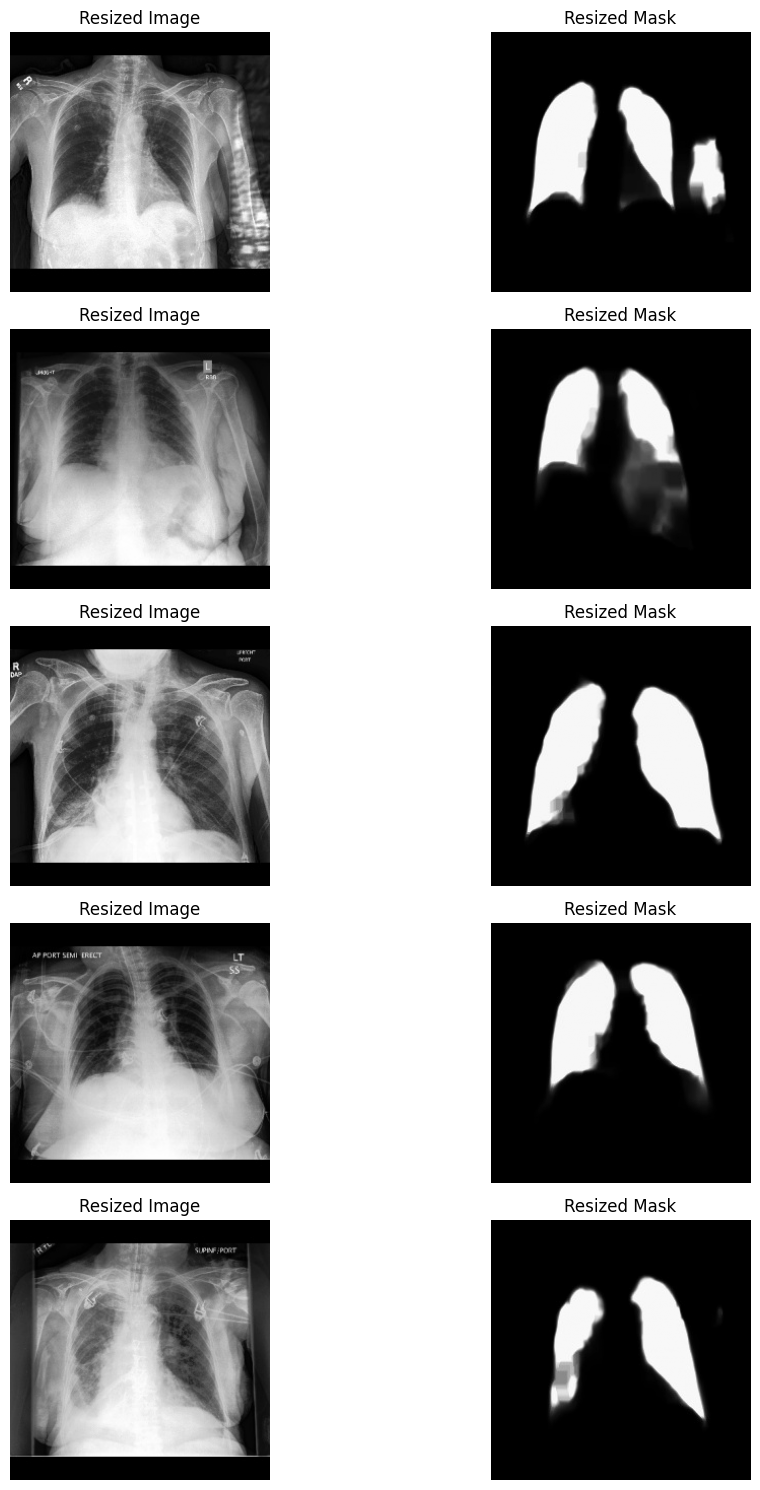

In [38]:
display_resized_samples(glob_valid_resize, mask_glob_valid, key_levels=3, num_samples=5)

[1] image: D:/Downloads/train_resized/patient12841/study2/view1_frontal.jpg
[1] key: patient12841/study2/view1_frontal
[1] mask: D:/Downloads/masks/train/patient12841/study2/view1_frontal_mask.jpg
[2] image: D:/Downloads/train_resized/patient12270/study1/view1_frontal.jpg
[2] key: patient12270/study1/view1_frontal
[2] mask: D:/Downloads/masks/train/patient12270/study1/view1_frontal_mask.jpg
[3] image: D:/Downloads/train_resized/patient55088/study1/view1_frontal.jpg
[3] key: patient55088/study1/view1_frontal
[3] mask: D:/Downloads/masks/train/patient55088/study1/view1_frontal_mask.jpg
[4] image: D:/Downloads/train_resized/patient36410/study1/view1_frontal.jpg
[4] key: patient36410/study1/view1_frontal
[4] mask: D:/Downloads/masks/train/patient36410/study1/view1_frontal_mask.jpg
[5] image: D:/Downloads/train_resized/patient40629/study1/view1_frontal.jpg
[5] key: patient40629/study1/view1_frontal
[5] mask: D:/Downloads/masks/train/patient40629/study1/view1_frontal_mask.jpg


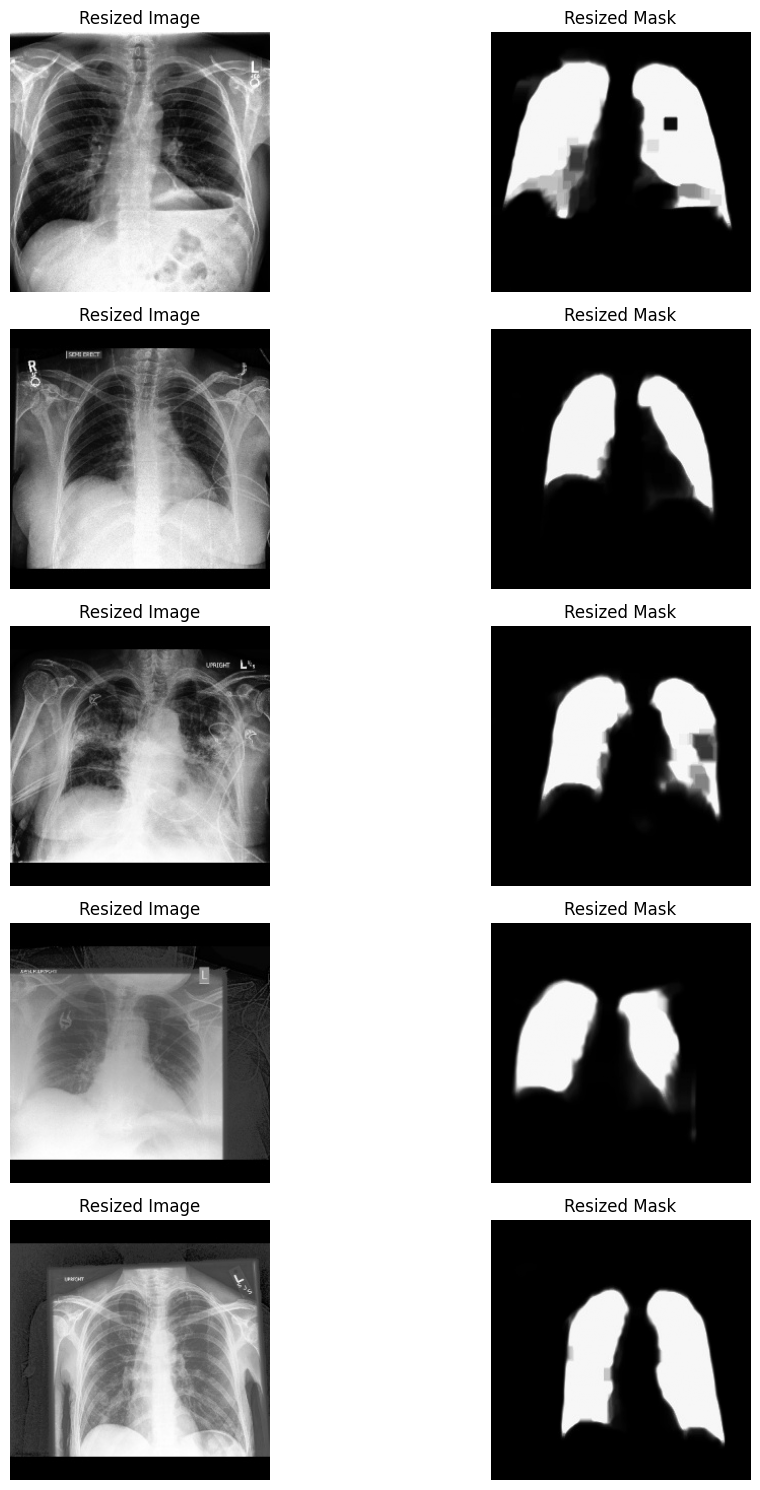

In [39]:
display_resized_samples(glob_train_resize, mask_glob_train, key_levels=3, num_samples=5)

# Combining Mask with Original Image

In [40]:
def convolutionize_mask(mask_glob, resize_glob, output_directory):
    os.makedirs(output_directory, exist_ok=True)
    glob = []
    
    for mask_path, image_path in zip(mask_glob, resize_glob):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if mask is None or image is None:
            print(f"Failed to read mask or image: {mask_path}, {image_path}")
            continue
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Convert mask to weights 0–1
        mask_float = mask.astype("float32") / 255.0

        # Convolve the image with a Gaussian kernel
        blurred = cv2.GaussianBlur(image, (5, 5), 0)

        # Convolution-style combination
        result = image * mask_float + blurred * (1 - mask_float)
        result = np.clip(result, 0, 255).astype("uint8")
        
        # Build output path
        parts = image_path.replace("\\", "/").split("/")
        relative_path = "/".join(parts[3:])
        output_path = os.path.join(output_directory, relative_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        directory, filename = os.path.split(output_path)
        name, ext = os.path.splitext(filename)
        new_filename = f"{name}_conv{ext}"
        output_path = os.path.join(directory, new_filename)
        
        # Save result
        success = cv2.imwrite(output_path, result)
        if success:
            print(f"✓ Saved: {output_path}")
            glob.append(output_path)
        else:
            print(f"✗ Failed to save: {output_path}")
    
    return glob


In [41]:
def check_convolutionized_images(mask_glob, img_glob, root_dir):
    valid_extensions = {".jpg", ".jpeg", ".png"}
    found = []
    os.makedirs(root_dir, exist_ok=True)

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions and name.endswith("_conv"):
                found.append(os.path.join(root, file))
    
    if found:
        print(f"Found {len(found)} convolutionized images.")
        return found
    else:
        print("No convolutionized images found. Proceed to generate convolutionized images.")
        return convolutionize_mask(mask_glob, img_glob, root_dir)

In [42]:
conv_output_valid = "D:/Downloads/conv_valid"
conv_glob_valid = check_convolutionized_images(mask_glob_valid, glob_valid_resize, conv_output_valid)

No convolutionized images found. Proceed to generate convolutionized images.
✓ Saved: D:/Downloads/conv_valid\patient64541/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_valid\patient64542/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_valid\patient64542/study1\view2_lateral_conv.jpg
✓ Saved: D:/Downloads/conv_valid\patient64543/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_valid\patient64544/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_valid\patient64545/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_valid\patient64546/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_valid\patient64547/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_valid\patient64547/study1\view2_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_valid\patient64547/study1\view3_lateral_conv.jpg
✓ Saved: D:/Downloads/conv_valid\patient64548/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_valid\patient64549/study1\view1_frontal_conv.jpg
✓ Saved: D:

In [43]:
conv_output_train = "D:/Downloads/conv_train"
conv_glob_train = check_convolutionized_images(mask_glob_train, glob_train_resize, conv_output_train)

No convolutionized images found. Proceed to generate convolutionized images.
✓ Saved: D:/Downloads/conv_train\patient00006/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00012/study3\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00023/study6\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00039/study7\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00042/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00059/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00066/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00067/study3\view2_lateral_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00069/study17\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00069/study27\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00069/study43\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00081/study1\view2_frontal_conv.jpg
✓ Saved:

In [44]:
valid_df = replace_path(valid_df, conv_glob_valid)
valid_df

path  Atelectasis  \
0    D:/Downloads/conv_valid/patient64541/study1/vi...            0   
1    D:/Downloads/conv_valid/patient64542/study1/vi...            0   
2    D:/Downloads/conv_valid/patient64542/study1/vi...            0   
3    D:/Downloads/conv_valid/patient64543/study1/vi...            0   
4    D:/Downloads/conv_valid/patient64544/study1/vi...            1   
..                                                 ...          ...   
229  D:/Downloads/conv_valid/patient64736/study1/vi...            0   
230  D:/Downloads/conv_valid/patient64737/study1/vi...            1   
231  D:/Downloads/conv_valid/patient64738/study1/vi...            1   
232  D:/Downloads/conv_valid/patient64739/study1/vi...            1   
233  D:/Downloads/conv_valid/patient64740/study1/vi...            1   

     Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0               0              0      0                 0  
1               0              0      0                 1  
2               0              0      0                 0  
3               0              0      1                 0  
4               0              0      0                 1  
..            ...            ...    ...               ...  
229             0              0      1                 1  
230             0              0      0                 0  
231             0              0      0                 0  
232             1              1      1                 1  
233             0              0      0                 0  

[234 rows x 6 columns]

In [45]:
train_df = replace_path(train_df, conv_glob_train)
train_df.head()

path  Atelectasis  \
0  D:/Downloads/conv_train/patient00006/study1/vi...            0   
1  D:/Downloads/conv_train/patient00012/study3/vi...            0   
2  D:/Downloads/conv_train/patient00023/study6/vi...            0   
3  D:/Downloads/conv_train/patient00039/study7/vi...            0   
4  D:/Downloads/conv_train/patient00042/study1/vi...            1   

   Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0             0              0      0                 0  
1             0              0      0                 1  
2             0              0      0                 0  
3             0              0      1                 0  
4             0              0      0                 1

In [46]:
IMG_SIZE = (256,256)
CHANNELS = 3

In [47]:
base_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           rotation_range=10,
                                                           width_shift_range=0.05,
                                                           height_shift_range=0.05,
                                                           zoom_range=0.1,
                                                           horizontal_flip=True)

base_gen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = base_gen.flow_from_dataframe(dataframe=train_df,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle=True,
                                         batch_size=16)

valid_gen = base_gen_valid.flow_from_dataframe(dataframe=valid_df,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle = True,
                                         batch_size=16)  


test_X, test_Y = next(base_gen.flow_from_dataframe(dataframe=valid_df,
                                                   directory=None,
                                                   x_col='path',
                                                   y_col=class_names,
                                                   class_mode='raw',
                                                   target_size=IMG_SIZE,
                                                   shuffle = True,
                                                   batch_size=16))

Found 10000 validated image filenames.
Found 234 validated image filenames.
Found 234 validated image filenames.


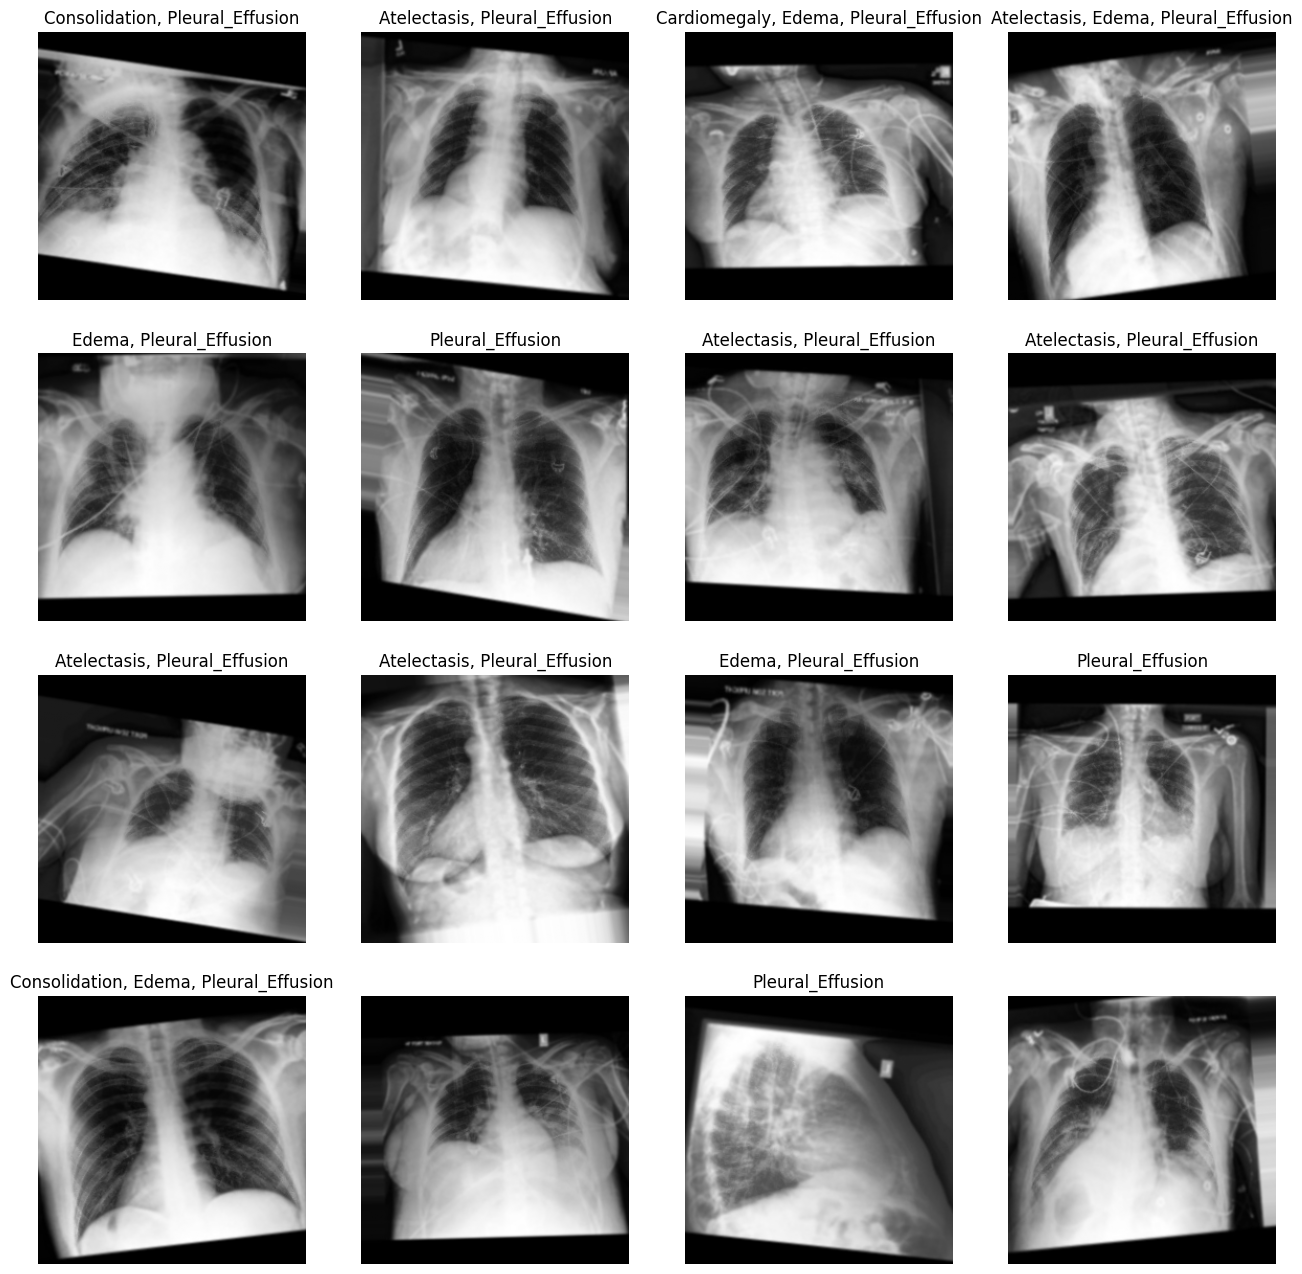

In [48]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,2], cmap='gray')
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(class_names, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# DenseNet Model 

My First Bookmark <a name='bookmark1' />

In [154]:
model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)

# Freeze sebagian besar layer
for layer in model.layers[:-30]:
    layer.trainable = False

x = model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(class_names), activation='sigmoid')(x)

model = tf.keras.Model(inputs=model.input, outputs=output)

In [155]:
from tensorflow.keras.losses import BinaryCrossentropy
loss_fn = BinaryCrossentropy(from_logits=False)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.AUC(multi_label=True, name="auc")
    ]
)

In [157]:
cb = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    )
]

In [158]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=1,
    callbacks=cb
)
model.save("densenet121_chexpert.hdf5")

625/625 ━━━━━━━━━━━━━━━━━━━━ 339s 524ms/step - auc: 0.5004 - loss: 0.5234 - val_auc: 0.4722 - val_loss: 0.5325 - learning_rate: 1.0000e-04


In [159]:
def learning_curves(history):
    # Ambil dictionary metric
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)

    import matplotlib.pyplot as plt
    import matplotlib.style as style
    style.use("bmh")

    # Membuat canvas 4 plot (loss, F1, macro AUC, micro AUC)
    plt.figure(figsize=(10, 14))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, hist['loss'], label='Training Loss')
    if 'val_loss' in hist:
        plt.plot(epochs, hist['val_loss'], label='Validation Loss')
    plt.legend()
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    # Plot AUC 
    plt.subplot(2, 1, 2)
    if 'auc_2' in hist:
        plt.plot(epochs, hist['auc_2'], label='Training AUC')
    if 'val_auc_2' in hist:
        plt.plot(epochs, hist['val_auc_2'], label='Validation AUC')
    plt.legend()
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epoch')

    plt.tight_layout()
    plt.show()


C:\Users\Zuhairil Abid\AppData\Local\Temp\ipykernel_13252\3096376423.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


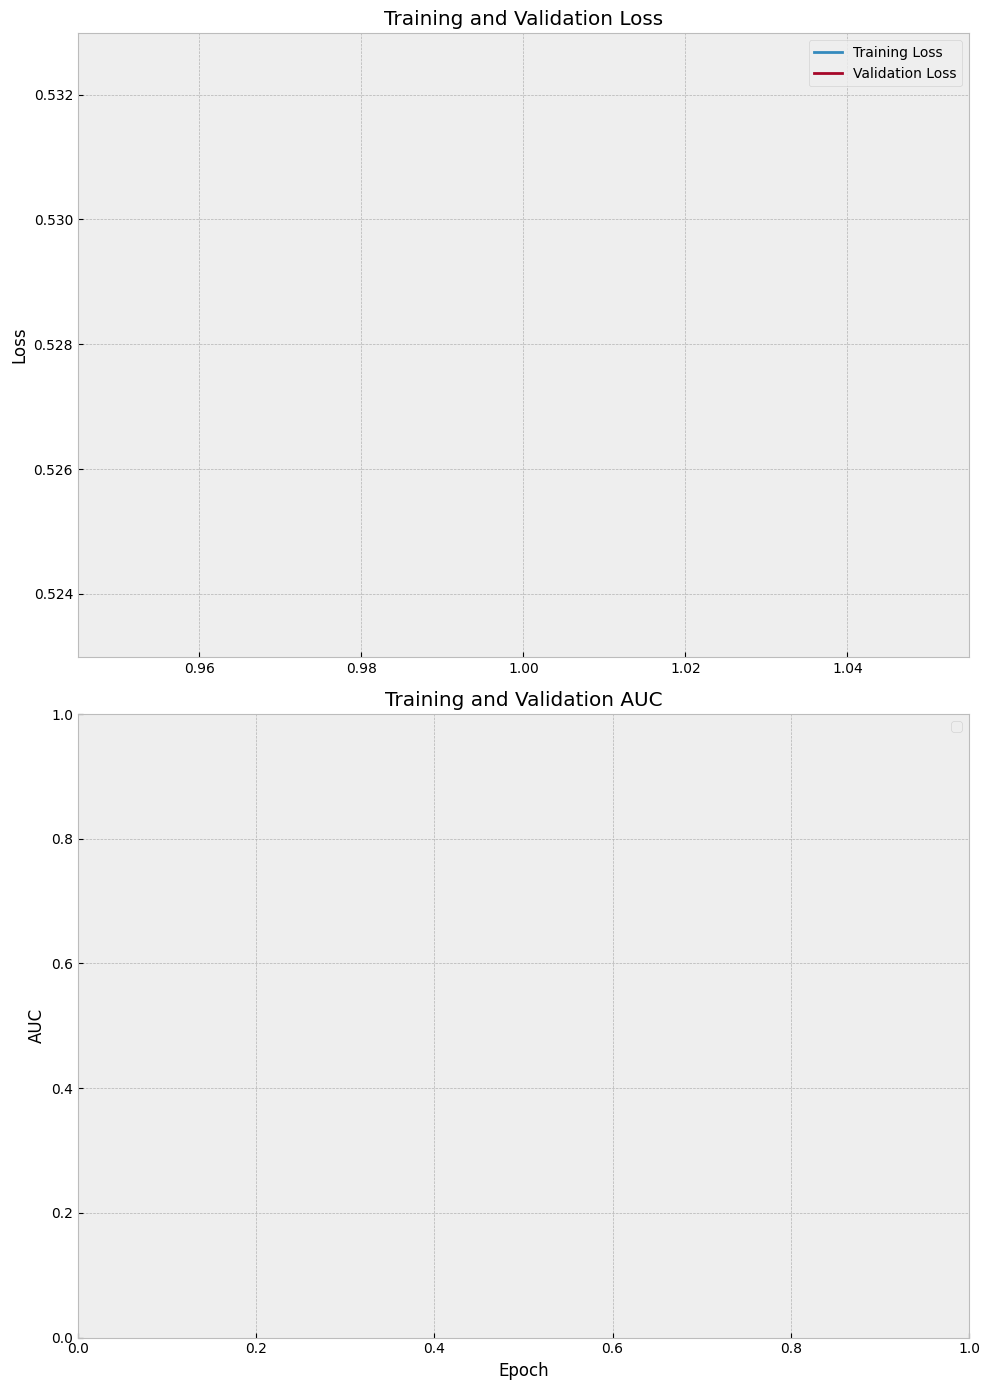

In [160]:
learning_curves(history)

In [180]:
def evaluate_confusion_matrices(model, valid_df, class_names, base_gen, IMG_SIZE, batch_size=16, thresh=0.1):
    from sklearn.metrics import confusion_matrix, classification_report, f1_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math
    
    # Non shuffled generator for evaluation
    valid_eval_gen = base_gen.flow_from_dataframe(
        dataframe=valid_df,
        directory=None,
        x_col='path',
        y_col=class_names,
        class_mode='raw',
        target_size=IMG_SIZE,
        shuffle=False,
        batch_size=batch_size
    )

    # Predict
    preds = model.predict(valid_eval_gen, verbose=0)
    y_true = valid_df[class_names].to_numpy()
    y_pred = (preds >= thresh).astype(int)

    # Classification report
    print("Classification report (per-class):")
    print(classification_report(
        y_true, 
        y_pred, 
        target_names=class_names, 
        zero_division=0
    ))

    print("Macro F1 (sklearn):", f1_score(y_true, y_pred, average='macro'))
    print("Micro F1 (sklearn):", f1_score(y_true, y_pred, average='micro'))

    # Confusion matrices per class
    n = len(class_names)
    cols = 2
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()

    for i, cls in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=[0, 1])
        sns.heatmap(
            cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues", 
            cbar=False,
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"],
            ax=axes[i]
        )
        axes[i].set_title(f"{cls} (Thresh={thresh})")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")

    # Hide unused subplot slots
    for j in range(n, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Classification report (per-class):
                  precision    recall  f1-score   support

     Atelectasis       0.32      1.00      0.49        76
    Cardiomegaly       0.15      0.71      0.25        35
   Consolidation       0.00      0.00      0.00        15
           Edema       0.26      1.00      0.41        60
Pleural_Effusion       0.43      0.99      0.60       100

       micro avg       0.30      0.91      0.45       286
       macro avg       0.23      0.74      0.35       286
    weighted avg       0.31      0.91      0.46       286
     samples avg       0.30      0.66      0.39       286

Macro F1 (sklearn): 0.34932080186194037
Micro F1 (sklearn): 0.44596912521440824


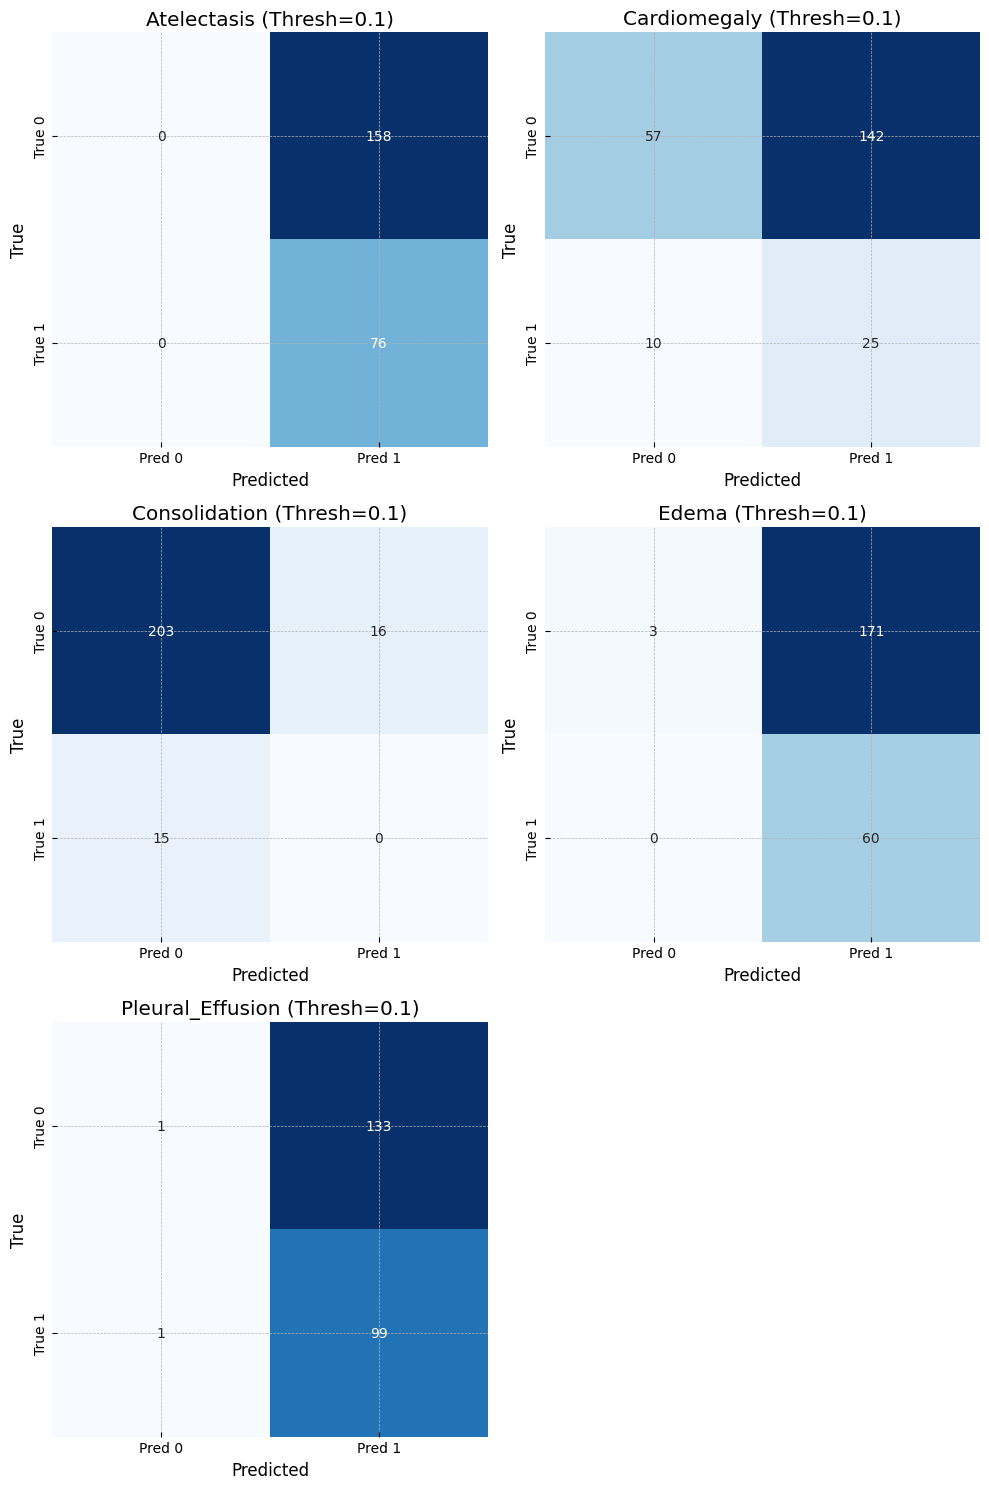

In [181]:
evaluate_confusion_matrices(model, valid_df, class_names, base_gen, IMG_SIZE)

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 533ms/step

AUC per class:
Atelectasis: 0.4683
Cardiomegaly: 0.5749
Consolidation: 0.5145
Edema: 0.5361
Pleural_Effusion: 0.4984

Macro AUC: 0.518414901927037
Micro AUC: 0.6747935322595956


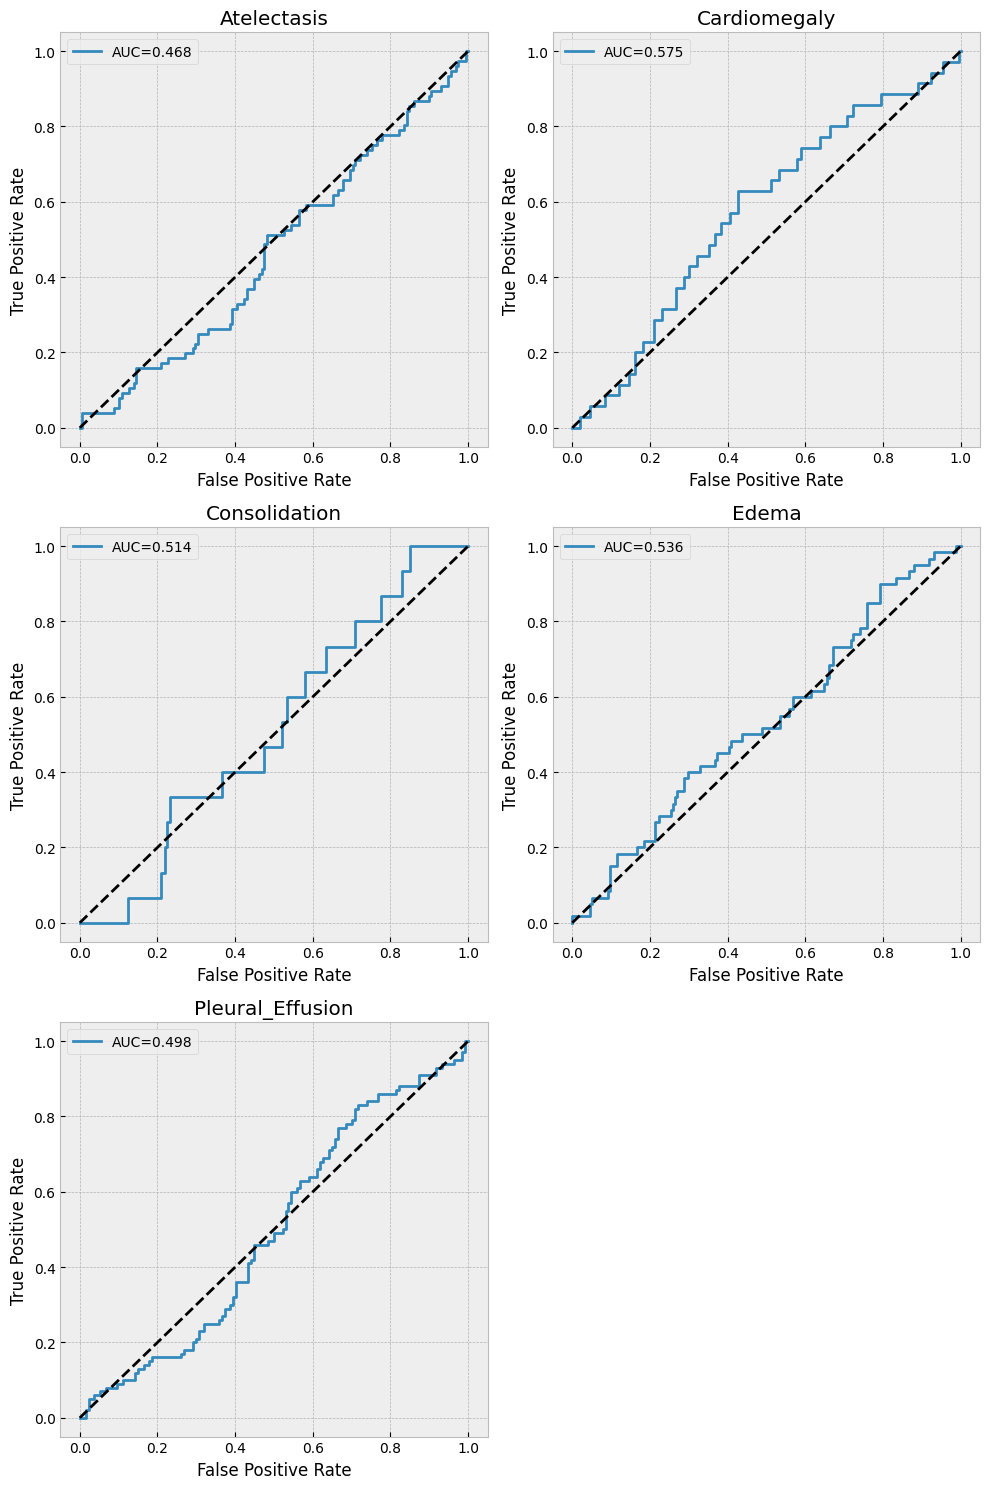

In [183]:
from sklearn.metrics import roc_auc_score
import math

# deterministic validation generator
BATCH_SIZE = 16

valid_eval_gen = base_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE
)

# get prediction probabilities
preds = model.predict(valid_eval_gen, verbose=1)
y_true = valid_df[class_names].to_numpy()

# compute AUC per class
auc_per_class = {}
for i, cls in enumerate(class_names):
    try:
        auc = roc_auc_score(y_true[:, i], preds[:, i])
    except ValueError:
        auc = float('nan')
    auc_per_class[cls] = auc

print("\nAUC per class:")
for cls, auc in auc_per_class.items():
    print(f"{cls}: {auc:.4f}")

# macro and micro AUC
try:
    macro_auc = roc_auc_score(y_true, preds, average='macro')
except ValueError:
    macro_auc = float('nan')

try:
    micro_auc = roc_auc_score(y_true, preds, average='micro')
except ValueError:
    micro_auc = float('nan')

print("\nMacro AUC:", macro_auc)
print("Micro AUC:", micro_auc)

# optional: plot ROC curves for each class
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

cols = 2
rows = math.ceil(len(class_names) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    try:
        fpr, tpr, _ = roc_curve(y_true[:, i], preds[:, i])
        axes[i].plot(fpr, tpr, label=f"AUC={auc_per_class[cls]:.3f}")
        axes[i].plot([0,1], [0,1], 'k--')
        axes[i].set_title(cls)
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        axes[i].legend()
    except ValueError:
        axes[i].set_title(f"{cls} (no positives)")
        axes[i].axis("off")

# hide unused plots
for j in range(len(class_names), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


# CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop

def build_simple_cnn(input_shape=(256,256,3), n_classes=len(class_names)):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(n_classes, activation='sigmoid'))
    return model


In [193]:
# build model
cnn_input_shape = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
cnn_model = build_simple_cnn(input_shape=cnn_input_shape, n_classes=len(class_names))

# use BinaryCrossentropy
loss_fn = BinaryCrossentropy(from_logits=False)

cnn_model.compile(
    optimizer=RMSprop(learning_rate=3e-5),
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.AUC(multi_label=True, name="auc")
    ]
)

# deterministic generators
cnn_valid_eval_gen = base_gen_valid.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=16
)

cnn_train_gen = base_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=True,
    batch_size=16
)

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 10000 validated image filenames.


In [194]:
# training
H_cnn = cnn_model.fit(
    cnn_train_gen,
    validation_data=(test_X, test_Y),
    epochs=1
)

cnn_model.save('simple_cnn.h5')

c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 404s 644ms/step - auc: 0.5057 - loss: 0.6933 - val_auc: 0.5583 - val_loss: 0.8738


C:\Users\Zuhairil Abid\AppData\Local\Temp\ipykernel_13252\3096376423.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


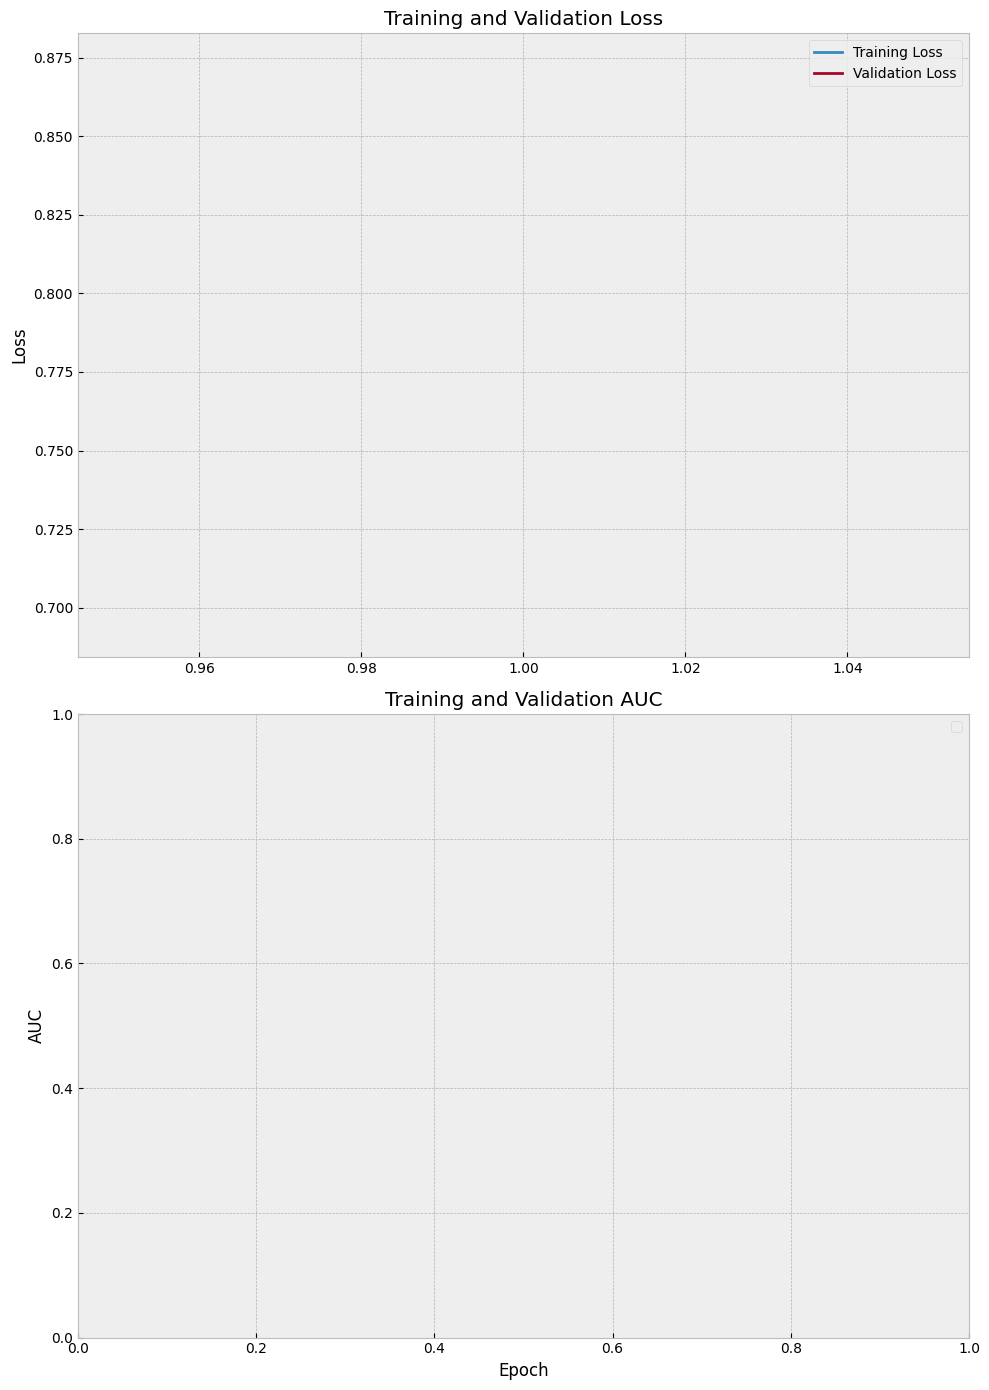

In [195]:
learning_curves(H_cnn)

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Classification report (per-class):
                  precision    recall  f1-score   support

     Atelectasis       0.33      0.82      0.47        76
    Cardiomegaly       0.00      0.00      0.00        35
   Consolidation       0.00      0.00      0.00        15
           Edema       0.00      0.00      0.00        60
Pleural_Effusion       0.43      1.00      0.60       100

       micro avg       0.38      0.57      0.46       286
       macro avg       0.15      0.36      0.21       286
    weighted avg       0.24      0.57      0.33       286
     samples avg       0.38      0.43      0.38       286

Macro F1 (sklearn): 0.21405951405951407
Micro F1 (sklearn): 0.4582743988684583


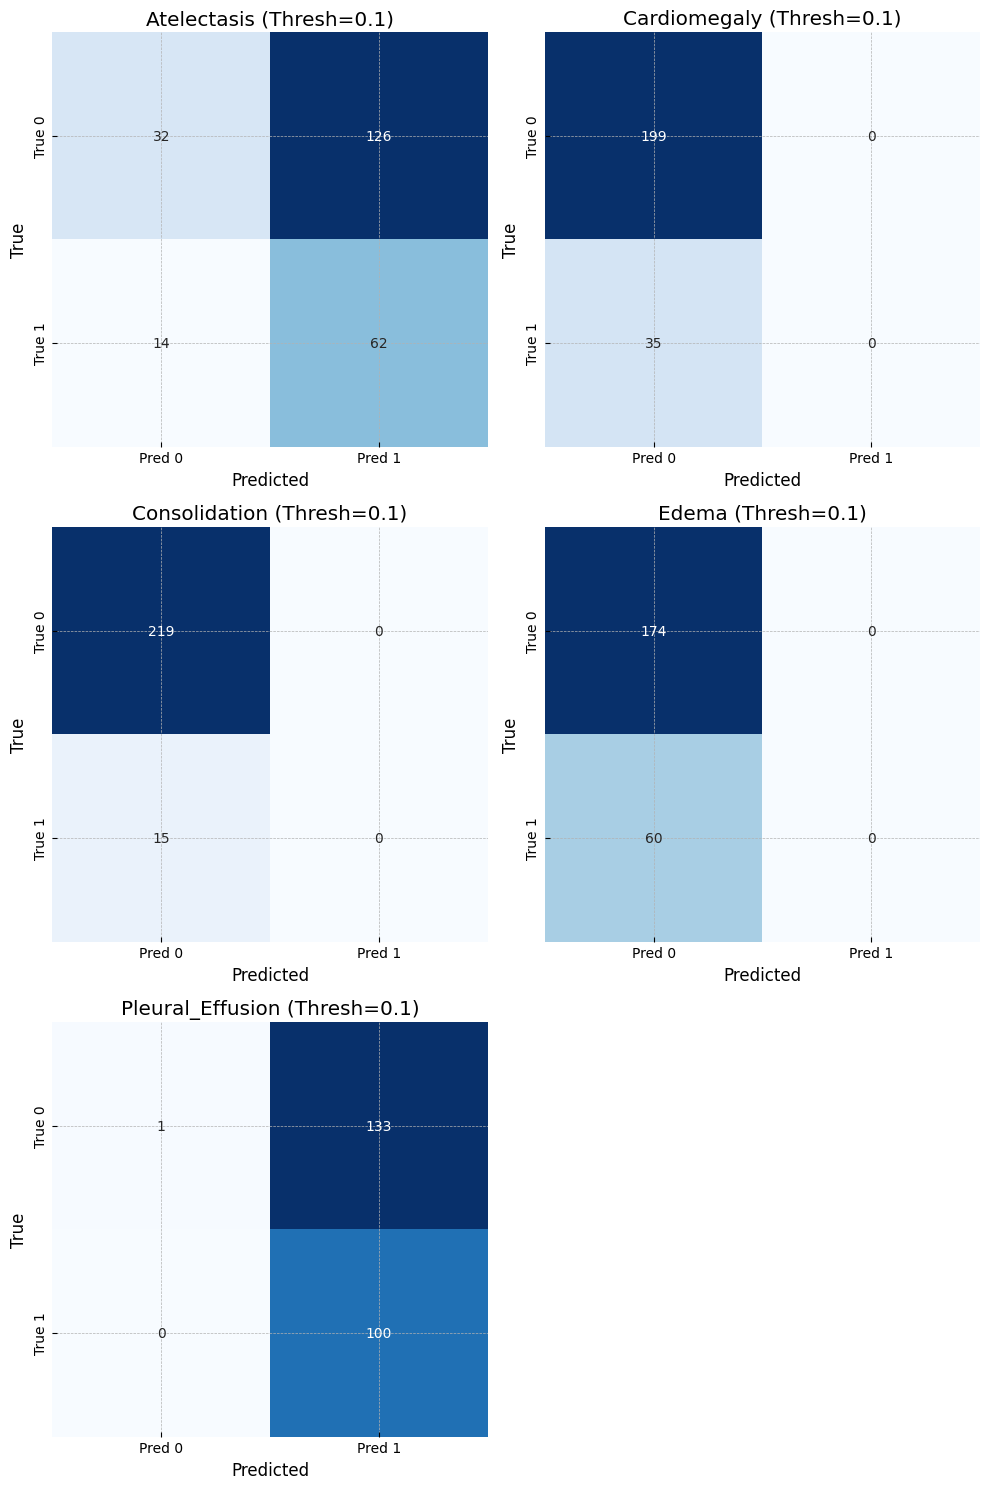

In [ ]:
evaluate_confusion_matrices(cnn_model, valid_df, class_names, base_gen_valid, IMG_SIZE)

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 634ms/step

AUC per class:
Atelectasis: 0.5067
Cardiomegaly: 0.4592
Consolidation: 0.4070
Edema: 0.5212
Pleural_Effusion: 0.4929

Macro AUC: 0.4773791369568025
Micro AUC: 0.6676858209663639


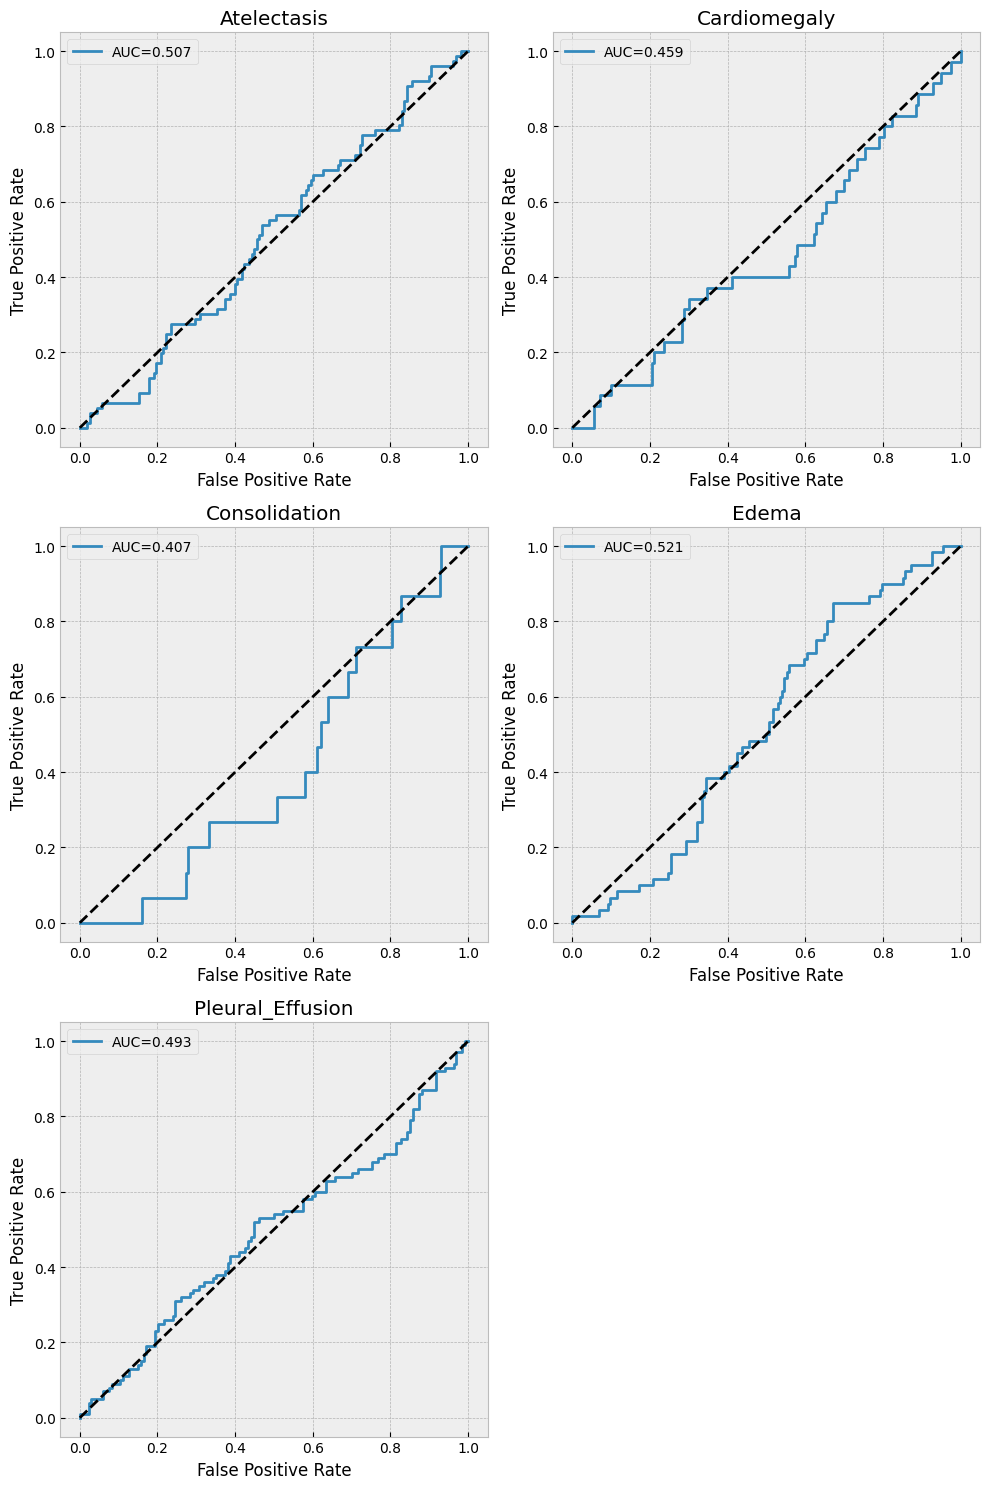

In [197]:
from sklearn.metrics import roc_auc_score
import math

# deterministic validation generator
BATCH_SIZE = 16

valid_eval_gen = base_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE
)

# get prediction probabilities
preds = model.predict(valid_eval_gen, verbose=1)
y_true = valid_df[class_names].to_numpy()

# compute AUC per class
auc_per_class = {}
for i, cls in enumerate(class_names):
    try:
        auc = roc_auc_score(y_true[:, i], preds[:, i])
    except ValueError:
        auc = float('nan')
    auc_per_class[cls] = auc

print("\nAUC per class:")
for cls, auc in auc_per_class.items():
    print(f"{cls}: {auc:.4f}")

# macro and micro AUC
try:
    macro_auc = roc_auc_score(y_true, preds, average='macro')
except ValueError:
    macro_auc = float('nan')

try:
    micro_auc = roc_auc_score(y_true, preds, average='micro')
except ValueError:
    micro_auc = float('nan')

print("\nMacro AUC:", macro_auc)
print("Micro AUC:", micro_auc)

# optional: plot ROC curves for each class
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

cols = 2
rows = math.ceil(len(class_names) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    try:
        fpr, tpr, _ = roc_curve(y_true[:, i], preds[:, i])
        axes[i].plot(fpr, tpr, label=f"AUC={auc_per_class[cls]:.3f}")
        axes[i].plot([0,1], [0,1], 'k--')
        axes[i].set_title(cls)
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        axes[i].legend()
    except ValueError:
        axes[i].set_title(f"{cls} (no positives)")
        axes[i].axis("off")

# hide unused plots
for j in range(len(class_names), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# ResNet-50

In [199]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import tensorflow as tf

def build_resnet50(input_shape=(256,256,3), n_classes=len(class_names), trainable=False):
    base_model_r = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model_r.trainable = trainable

    x = base_model_r.output
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(n_classes, activation='sigmoid')(x)

    model_r = tf.keras.Model(inputs=base_model_r.input, outputs=outputs)
    return model_r



In [200]:
# Build, compile and train ResNet50 (same as DenseNet121)
resnet_input_shape = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
resnet_model = build_resnet50(
    input_shape=resnet_input_shape,
    n_classes=len(class_names),
    trainable=False
)

resnet_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.AUC()]
)

# Generators
resnet_train_gen = base_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=True,
    batch_size=16
)

resnet_valid_eval_gen = base_gen_valid.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=16
)


Found 10000 validated image filenames.
Found 234 validated image filenames.


In [201]:
# Train
H_resnet = resnet_model.fit(
    resnet_train_gen,
    validation_data=(test_X, test_Y),
    epochs=1
)
resnet_model.save("ResNet50.h5")

c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 280s 437ms/step - auc_3: 0.6527 - loss: 0.5381 - val_auc_3: 0.5988 - val_loss: 0.5453


C:\Users\Zuhairil Abid\AppData\Local\Temp\ipykernel_13252\3096376423.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


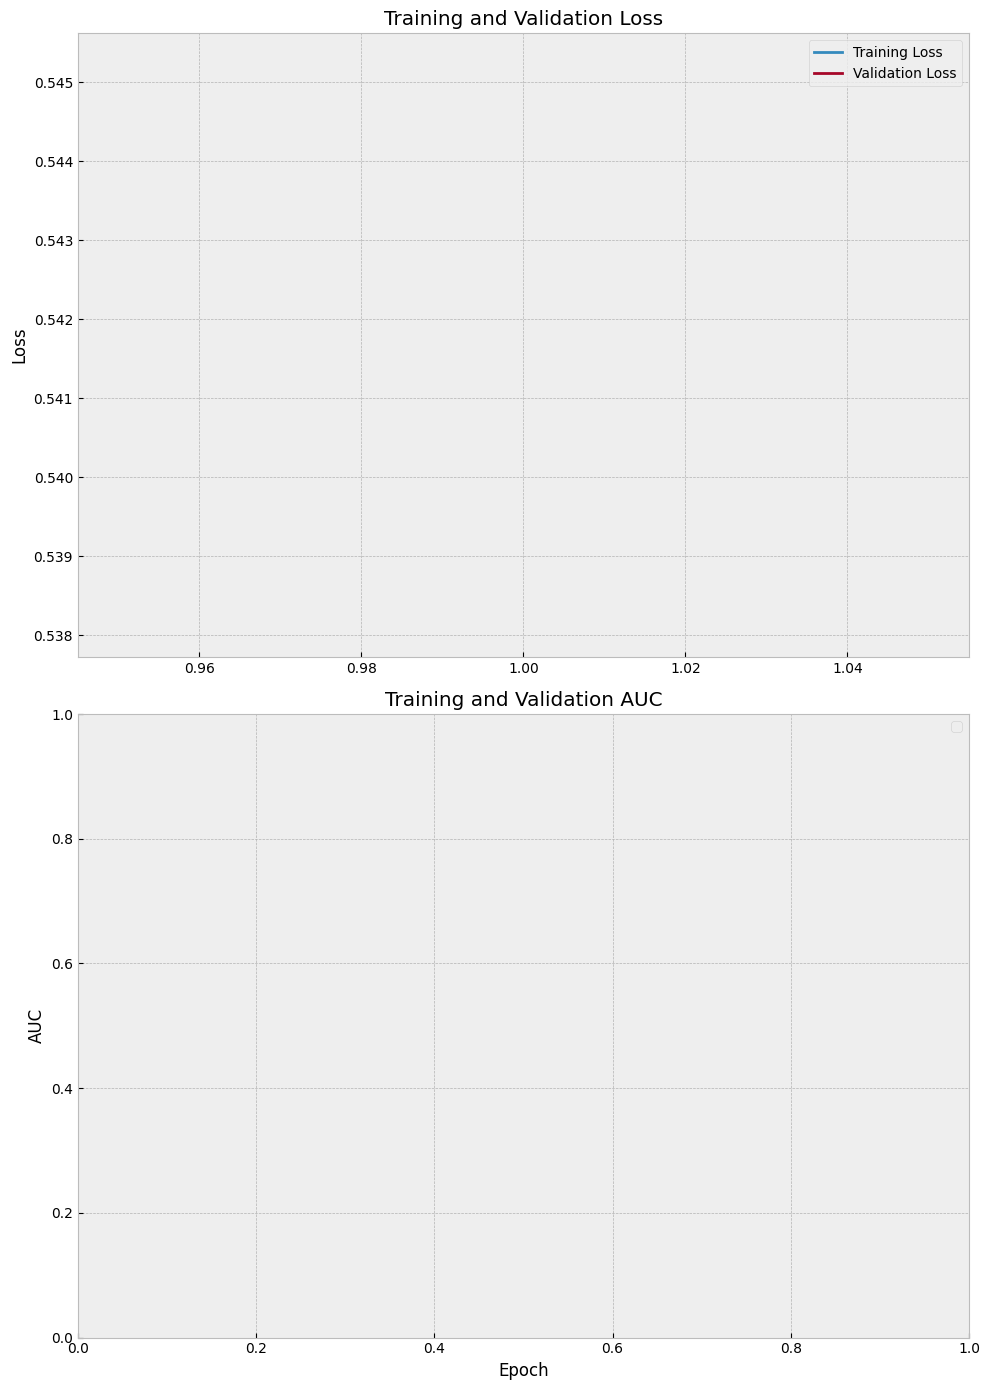

In [202]:
learning_curves(H_resnet)

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Classification report (per-class):
                  precision    recall  f1-score   support

     Atelectasis       0.32      1.00      0.49        76
    Cardiomegaly       0.15      1.00      0.26        35
   Consolidation       0.00      0.00      0.00        15
           Edema       0.26      1.00      0.41        60
Pleural_Effusion       0.43      1.00      0.60       100

       micro avg       0.29      0.95      0.44       286
       macro avg       0.23      0.80      0.35       286
    weighted avg       0.31      0.95      0.46       286
     samples avg       0.29      0.69      0.39       286

Macro F1 (sklearn): 0.3515022578976004
Micro F1 (sklearn): 0.44353518821603927


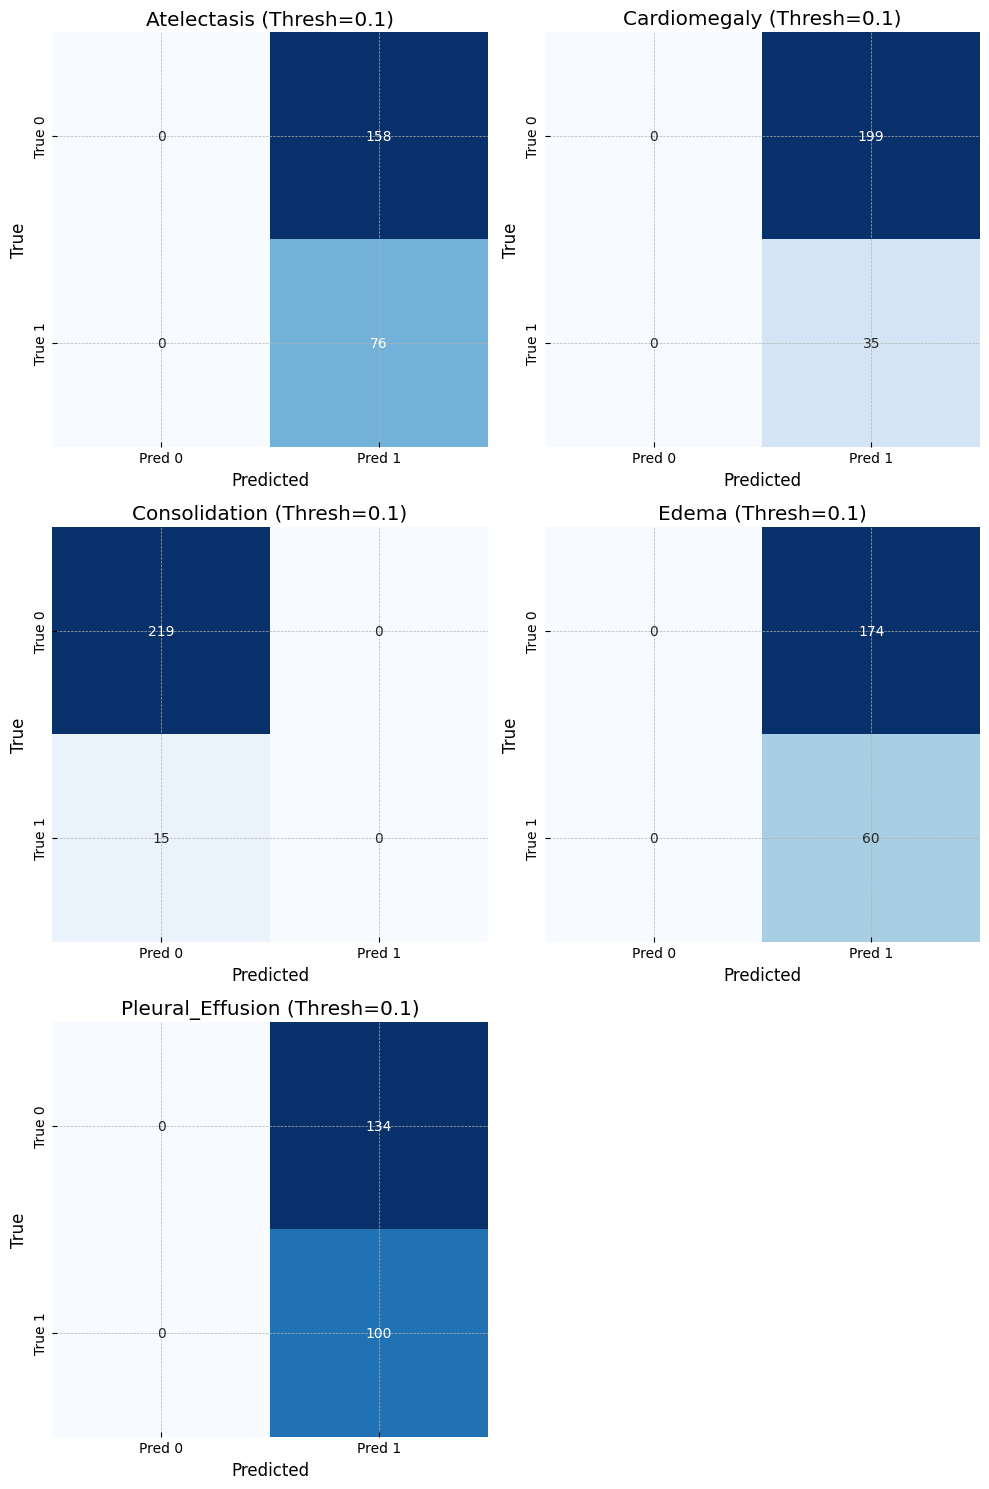

In [203]:
evaluate_confusion_matrices(resnet_model, valid_df, class_names, base_gen_valid, IMG_SIZE)

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 480ms/step

AUC per class:
Atelectasis: 0.4640
Cardiomegaly: 0.5420
Consolidation: 0.3912
Edema: 0.5561
Pleural_Effusion: 0.4428

Macro AUC: 0.47923155195331946
Micro AUC: 0.6582800683479417


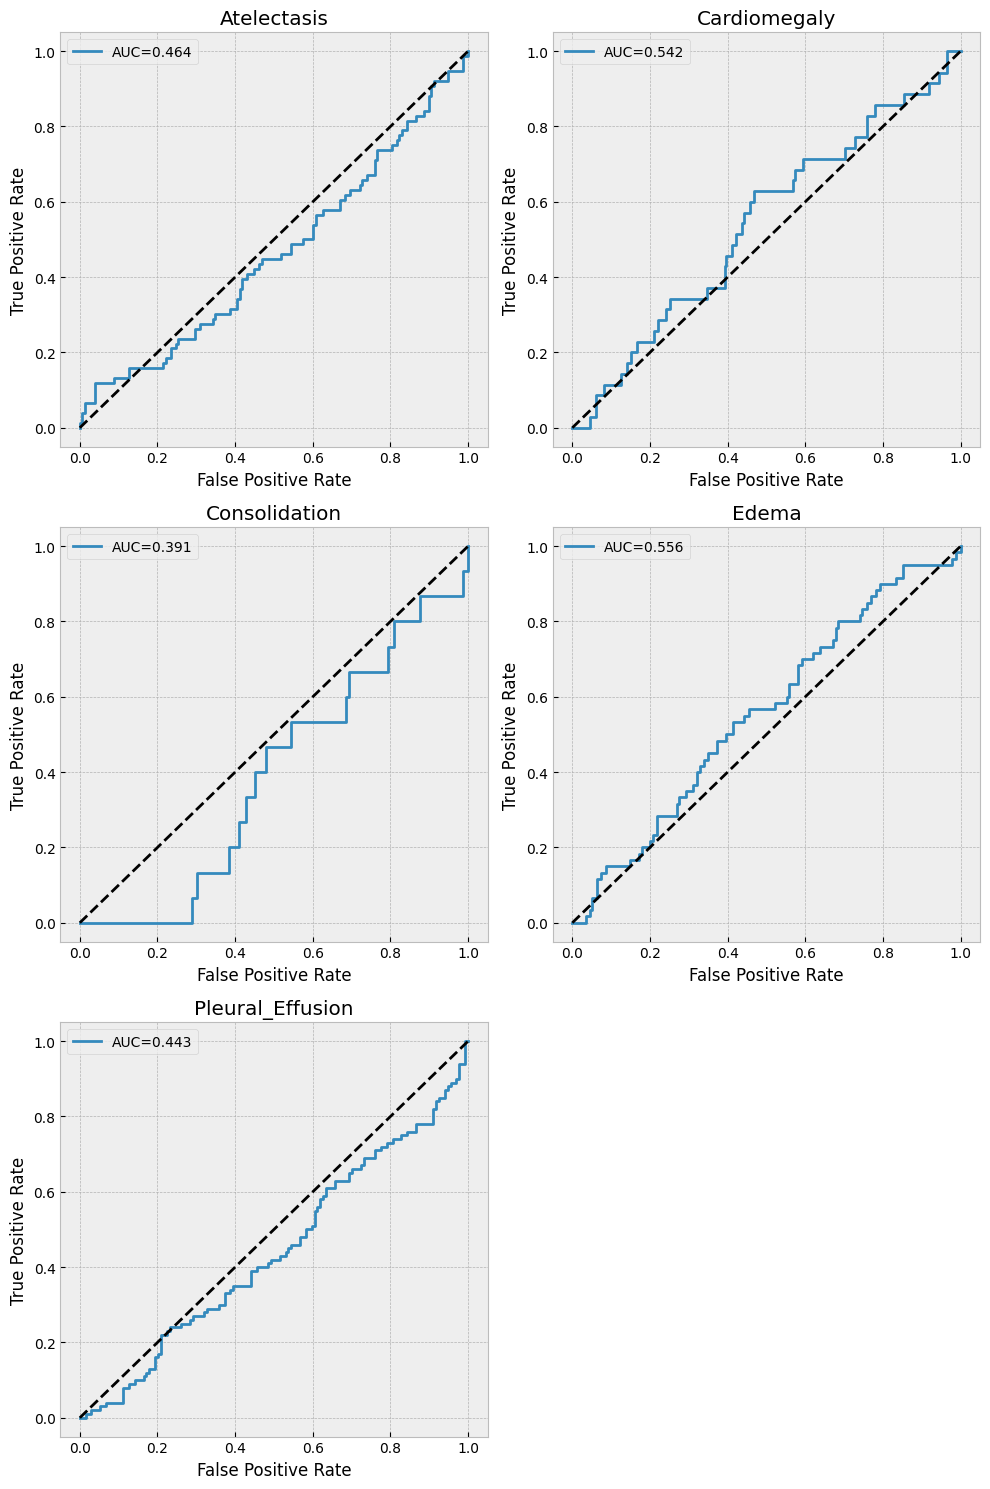

In [204]:
from sklearn.metrics import roc_auc_score
import math

# deterministic validation generator
BATCH_SIZE = 16

valid_eval_gen = base_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE
)

# get prediction probabilities
preds = model.predict(valid_eval_gen, verbose=1)
y_true = valid_df[class_names].to_numpy()

# compute AUC per class
auc_per_class = {}
for i, cls in enumerate(class_names):
    try:
        auc = roc_auc_score(y_true[:, i], preds[:, i])
    except ValueError:
        auc = float('nan')
    auc_per_class[cls] = auc

print("\nAUC per class:")
for cls, auc in auc_per_class.items():
    print(f"{cls}: {auc:.4f}")

# macro and micro AUC
try:
    macro_auc = roc_auc_score(y_true, preds, average='macro')
except ValueError:
    macro_auc = float('nan')

try:
    micro_auc = roc_auc_score(y_true, preds, average='micro')
except ValueError:
    micro_auc = float('nan')

print("\nMacro AUC:", macro_auc)
print("Micro AUC:", micro_auc)

# optional: plot ROC curves for each class
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

cols = 2
rows = math.ceil(len(class_names) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    try:
        fpr, tpr, _ = roc_curve(y_true[:, i], preds[:, i])
        axes[i].plot(fpr, tpr, label=f"AUC={auc_per_class[cls]:.3f}")
        axes[i].plot([0,1], [0,1], 'k--')
        axes[i].set_title(cls)
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        axes[i].legend()
    except ValueError:
        axes[i].set_title(f"{cls} (no positives)")
        axes[i].axis("off")

# hide unused plots
for j in range(len(class_names), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [205]:
def evaluate_model_for_comparison(model, model_name, history, valid_df, base_gen, target_size, class_names, thresh=0.5, batch_size=16):
    # Deterministic generator for validation
    eval_gen = base_gen.flow_from_dataframe(
        dataframe=valid_df,
        directory=None,
        x_col='path',
        y_col=class_names,
        class_mode='raw',
        target_size=target_size,
        shuffle=False,
        batch_size=batch_size
    )

    # Prediction probabilities
    preds = model.predict(eval_gen, verbose=1)
    y_true = valid_df[class_names].to_numpy()
    y_pred_bin = (preds >= thresh).astype(int)

    # Classification report & F1s
    report = classification_report(y_true, y_pred_bin, target_names=class_names, zero_division=0, output_dict=True)
    sk_macro_f1 = None
    sk_micro_f1 = None
    try:
        sk_macro_f1 = f1_score(y_true, y_pred_bin, average='macro')
        sk_micro_f1 = f1_score(y_true, y_pred_bin, average='micro')
    except Exception:
        sk_macro_f1 = float('nan')
        sk_micro_f1 = float('nan')
    macro_f1_train = None
    macro_f1_val = None
    if history is not None and hasattr(history, 'history'):
        hist = history.history
        macro_f1_train = hist.get('macro_f1', [None])[-1]
        macro_f1_val = hist.get('val_macro_f1', [None])[-1]

    # Per-class confusion matrices
    cm_per_class = {}
    for i, cls in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred_bin[:, i], labels=[0, 1])
        cm_per_class[cls] = cm

    # AUC per class
    auc_per_class = {}
    for i, cls in enumerate(class_names):
        try:
            auc = roc_auc_score(y_true[:, i], preds[:, i])
        except Exception:
            auc = float('nan')
        auc_per_class[cls] = auc

    try:
        macro_auc = roc_auc_score(y_true, preds, average='macro')
    except Exception:
        macro_auc = float('nan')
    try:
        micro_auc = roc_auc_score(y_true, preds, average='micro')
    except Exception:
        micro_auc = float('nan')

    return {
        'model_name': model_name,
        'preds': preds,
        'y_true': y_true,
        'y_pred_bin': y_pred_bin,
        'report': report,
        'cm_per_class': cm_per_class,
        'auc_per_class': auc_per_class,
        'macro_auc': macro_auc,
        'micro_auc': micro_auc,
        'macro_f1_train': macro_f1_train,
        'macro_f1_val': macro_f1_val,
        'sk_macro_f1': sk_macro_f1,
        'sk_micro_f1': sk_micro_f1,
        'history': history
    }

In [206]:
def compare_models_and_report(models_info, class_names, out_csv='model_comparison.csv'):
    """Given a list of evaluation dictionaries (returned by evaluate_model_for_comparison),
    build a comparison DataFrame, write to CSV and produce summary plots.
    """
    rows = []
    for info in models_info:
        row = {
            'model': info['model_name'],
            'final_train_macro_f1': info.get('macro_f1_train'),
            'final_val_macro_f1': info.get('macro_f1_val'),
            'macro_auc': info.get('macro_auc'),
            'micro_auc': info.get('micro_auc')
        }
        # add sklearn F1s
        row['sk_macro_f1'] = info.get('sk_macro_f1')
        row['sk_micro_f1'] = info.get('sk_micro_f1')
        # add per-class AUC as columns
        for cls, auc in info.get('auc_per_class', {}).items():
            row[f'auc_{cls}'] = auc
        # add per-class F1 from the classification report
        for cls, rep in info.get('report', {}).items():
            if cls in class_names:
                row[f'f1_{cls}'] = rep.get('f1-score', float('nan'))
        rows.append(row)

    comp_df = pd.DataFrame(rows).set_index('model')
    comp_df.to_csv(out_csv)
    print(f"Wrote model comparison table to {out_csv}")

    # bar charts: macro F1 and macro AUC
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    comp_df[['final_train_macro_f1', 'final_val_macro_f1']].plot(kind='bar', ax=ax[0])
    ax[0].set_title('Macro F1 (Train/Val)')
    ax[0].set_ylabel('Macro F1')

    comp_df[['macro_auc']].plot(kind='bar', ax=ax[1], color=['darkgreen'])
    ax[1].set_title('Macro AUC (Validation)')
    ax[1].set_ylabel('AUC')
    plt.tight_layout()
    plt.show()

    # Confusion matrix grid: per-class comparison across models
    n_classes = len(class_names)
    for i, cls in enumerate(class_names):
        fig, axes = plt.subplots(1, len(models_info), figsize=(5 * len(models_info), 4))
        if len(models_info) == 1:
            axes = [axes]
        for ax_idx, info in enumerate(models_info):
            cm = info['cm_per_class'][cls]
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'], ax=axes[ax_idx])
            axes[ax_idx].set_title(f"{info['model_name']} - {cls}")
            axes[ax_idx].set_ylabel('True')
            axes[ax_idx].set_xlabel('Predicted')
        plt.tight_layout()
        plt.show()

    return comp_df


=== Performing final model evaluations for comparison ===
Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 485ms/step
Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step
Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step
Wrote model comparison table to model_comparison.csv


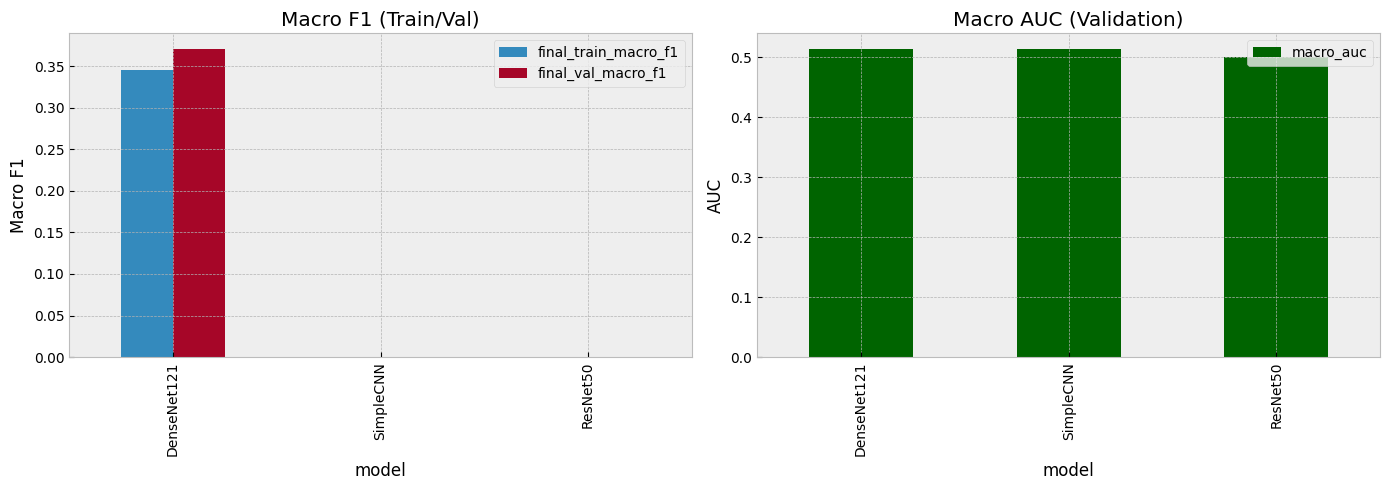

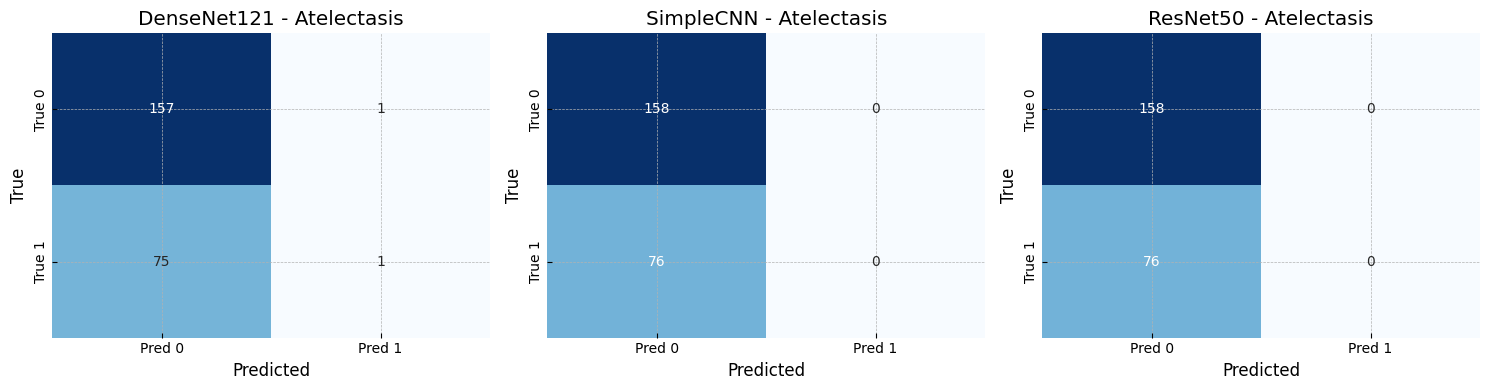

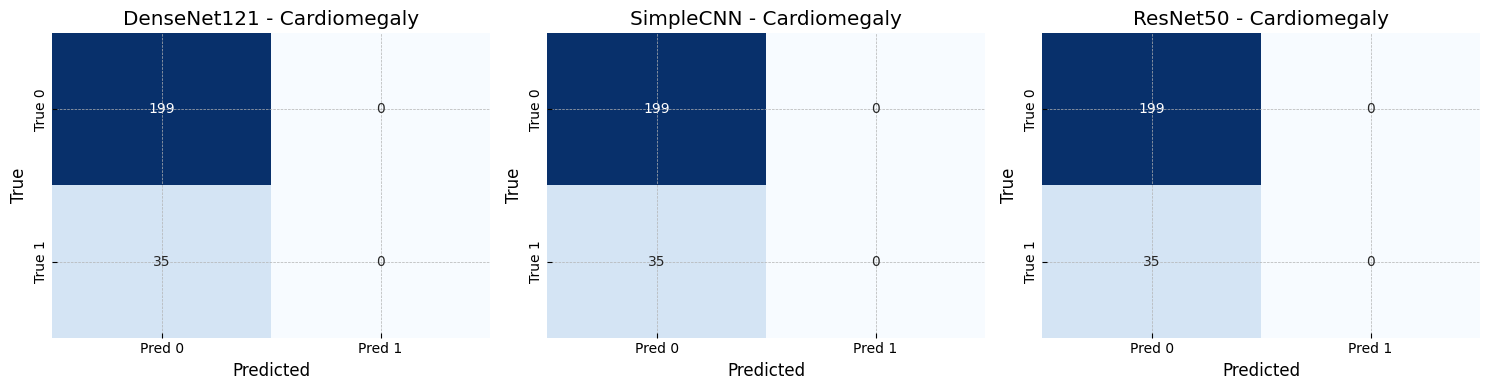

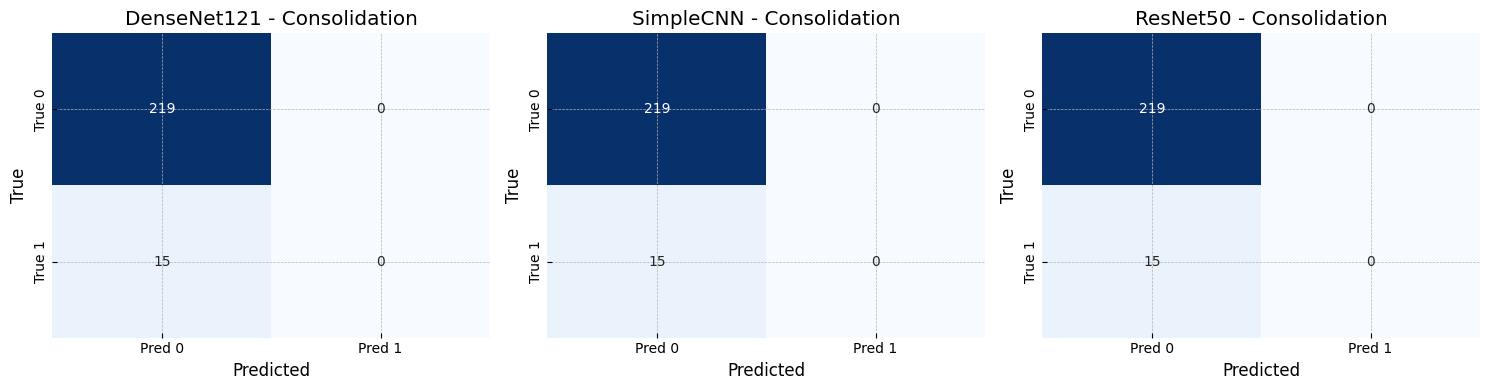

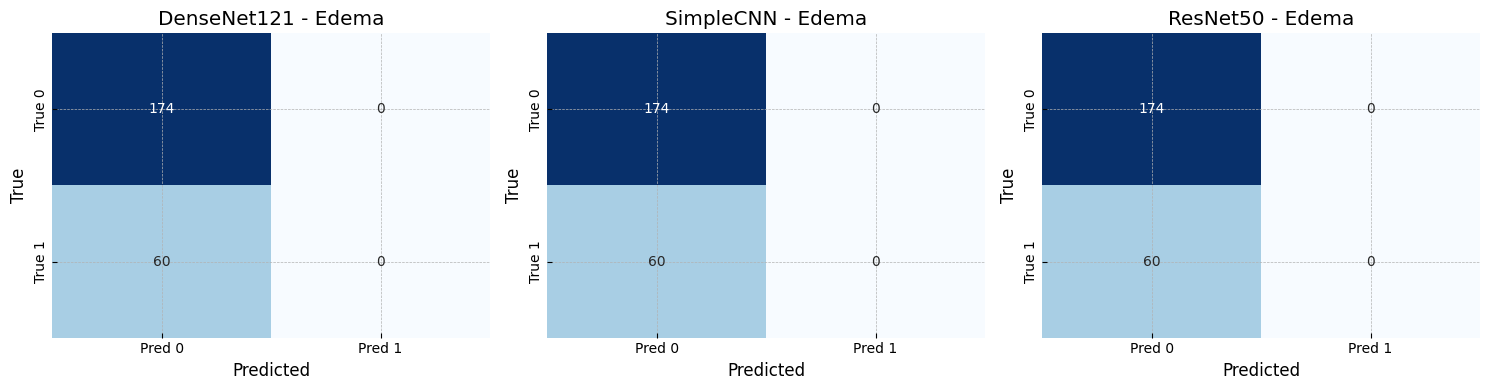

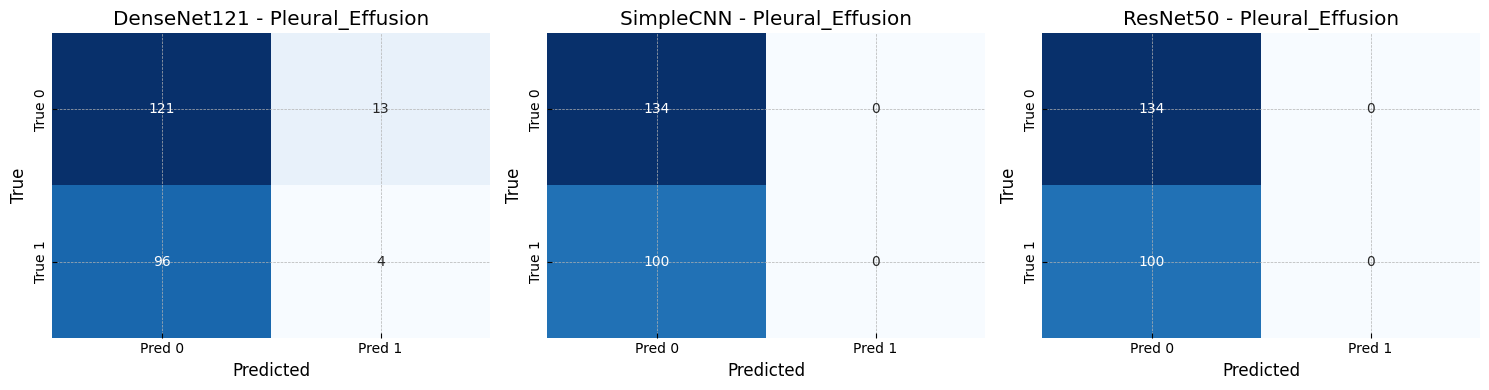


Model comparison (head):
             final_train_macro_f1  final_val_macro_f1  macro_auc  micro_auc  \
model                                                                         
DenseNet121              0.345859            0.371016   0.514563   0.677653   
SimpleCNN                     NaN                 NaN   0.513515   0.689080   
ResNet50                      NaN                 NaN   0.501139   0.698537   

             sk_macro_f1  sk_micro_f1  auc_Atelectasis  auc_Cardiomegaly  \
model                                                                      
DenseNet121     0.018803     0.032787         0.533394          0.479397   
SimpleCNN       0.000000     0.000000         0.460360          0.511127   
ResNet50        0.000000     0.000000         0.558294          0.472793   

             auc_Consolidation  auc_Edema  auc_Pleural_Effusion  \
model                                                             
DenseNet121           0.511416   0.590996              0.457612

In [207]:
try:
    print('\n=== Performing final model evaluations for comparison ===')
    densenet_info = evaluate_model_for_comparison(model, 'DenseNet121', H, valid_df, base_gen, IMG_SIZE, class_names, thresh=0.5)
    cnn_info = evaluate_model_for_comparison(cnn_model, 'SimpleCNN', H_cnn, valid_df, base_gen, IMG_SIZE, class_names, thresh=0.5)
    resnet_info = evaluate_model_for_comparison(resnet_model, 'ResNet50', H_resnet, valid_df, base_gen, IMG_SIZE, class_names, thresh=0.5)

    comparison_df = compare_models_and_report([densenet_info, cnn_info, resnet_info], class_names)
    print('\nModel comparison (head):')
    print(comparison_df.head())
except Exception as e:
    print('Error during model comparison:', e)

In [208]:
models = load_model("ResNet50.h5")

In [209]:
# confirm preds shape and ranges
print("preds shape:", preds.shape)
print("preds min/max per class:", preds.min(axis=0), preds.max(axis=0))
print("preds mean per class:", preds.mean(axis=0))

# counts of predicted positives per class and true positives per class
print("pred positive counts:", (preds >= 0.5).sum(axis=0))
print("true positive counts:", y_true.sum(axis=0))

# quick sample of preds and labels
for i, cls in enumerate(class_names):
    print(cls, "sample preds:", preds[:5, i], "sample trues:", y_true[:5, i])

# check model last layer and loss
model.summary()
print("compiled loss:", getattr(model, "loss", "not accessible"))

preds shape: (234, 5)
preds min/max per class: [0.10212416 0.01895785 0.02167019 0.07232465 0.07317843] [0.5891216  0.29663616 0.16187069 0.40285626 0.5727488 ]
preds mean per class: [0.31449202 0.13718143 0.05742754 0.22134353 0.3420585 ]
pred positive counts: [ 6  0  0  0 15]
true positive counts: [ 76  35  15  60 100]
Atelectasis sample preds: [0.3203602  0.26320073 0.30593392 0.32720047 0.2965966 ] sample trues: [0 0 0 0 1]
Cardiomegaly sample preds: [0.11542217 0.12284463 0.09324358 0.10502452 0.21194068] sample trues: [0 0 0 0 0]
Consolidation sample preds: [0.0420825  0.07137629 0.066585   0.0323345  0.02740669] sample trues: [0 0 0 0 0]
Edema sample preds: [0.21414816 0.25657213 0.12948838 0.3253358  0.1929381 ] sample trues: [0 0 0 1 0]
Pleural_Effusion sample preds: [0.36816162 0.14580745 0.4091108  0.3739779  0.20447978] sample trues: [0 1 0 0 1]


Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_20   │ (None, 262, 262,  │          0 │ input_layer_13[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_21   │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_2… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 8,335,697 (31.80 MB)

 Trainable params: 646,533 (2.47 MB)

 Non-trainable params: 6,396,096 (24.40 MB)

 Optimizer params: 1,293,068 (4.93 MB)

compiled loss: <LossFunctionWrapper(<function binary_crossentropy at 0x00000125D102EA20>, kwargs={'from_logits': False, 'label_smoothing': 0.0, 'axis': -1})>
